# Build MI Network from types and samples

## Libs

In [2]:
import os
import scanpy as sc
from itertools import compress
import pandas as pd
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries/'

## Check datas

Check for which dests we have combined embeds, and just the query objects.
We have different stages of annotation as backups.
- *filter*: Only the quality control filters
- *query*: The dataset reduced to the genes to be queried
- *combined*: The dataset combined with the atlas for label propagation
- *latent*: The dataset reduced by an autoencoder to the relevant dimension

The combined is the only one with annotations

In [2]:
backup_h5ds = os.listdir(backup_dir)
latent_h5ds = list(compress(backup_h5ds,['latent' in h5d for h5d in backup_h5ds]))
query_h5ds = list(compress(backup_h5ds,['query' in h5d for h5d in backup_h5ds]))
combined_h5ds = list(compress(backup_h5ds,['combined' in h5d for h5d in backup_h5ds]))
filter_h5ds = list(compress(backup_h5ds,['filtered' in h5d for h5d in backup_h5ds]))

In [43]:
print(len(filter_h5ds))
filter_h5ds

13


['filtered_Lambrechts_2018_LUAD_6653.h5ad',
 'filtered_Zilionis_Klein_2019_NSCLC.h5ad',
 'filtered_Lambrechts_2018_LUAD_6149v1.h5ad',
 'filtered_UKIM-V-2.h5ad',
 'filtered_Kim_Lee_2020_LUAD.h5ad',
 'filtered_UKIM-V.h5ad',
 'filtered_Goveia_Carmeliet_2020_NSCLC.h5ad',
 'filtered_Maynard_Bivona_2020_NSCLC.h5ad',
 'filtered_He_Fan_2021_LUAD.h5ad',
 'filtered_Wu_Zhou_2021_NSCLC.h5ad',
 'filtered_Chen_Zhang_2020_NSCLC.h5ad',
 'filtered_Laughney_Massague_2020_NSCLC.h5ad',
 'filtered_Lambrechts_2018_LUAD_6149v2.h5ad']

In [38]:
query_h5ds

['query_Laughney_Massague_2020_NSCLC.h5ad',
 'query_Goveia_Carmeliet_2020_NSCLC.h5ad',
 'query_Lambrechts_2018_LUAD_6149v1.h5ad',
 'query_Zilionis_Klein_2019_NSCLC.h5ad',
 'query_Lambrechts_2018_LUAD_6653.h5ad',
 'query_emb_Leader.h5ad',
 'query_UKIM-V.h5ad',
 'query_Lambrechts_2018_LUAD_6149v2.h5ad',
 'query_Wu_Zhou_2021_NSCLC.h5ad',
 'query_Adams_Kaminski_2020_COPD.h5ad',
 'query_Maynard_Bivona_2020_NSCLC.h5ad',
 'query_He_Fan_2021_LUAD.h5ad',
 'query_Travaglini_Krasnow_2020_Lung_10x.h5ad',
 'query_Madissoon_Meyer_2020_pulmonary-fibrosis.h5ad',
 'query_Leader_Merad_2021_10x_3p_v1_sort.h5ad',
 'query_Chen_Zhang_2020_NSCLC.h5ad',
 'query_Kim_Lee_2020_LUAD.h5ad',
 'query_Habermann_Kropski_2020_pulmonary-fibrosis.h5ad',
 'query_Reyfman_Misharin_2018_pulmonary-fibrosis.h5ad',
 'query_Emilio.h5ad',
 'query_Mayr_Schiller_2020_pulmonary-fibrosis.h5ad']

In [ ]:
latent_h5ds

['latent_Lambrechts_2018_LUAD_6149v2.h5ad',
 'latent_Chen_Zhang_2020_NSCLC.h5ad',
 'latent_Madissoon_Meyer_2020_pulmonary-fibrosis.h5ad',
 'latent_Emilio.h5ad',
 'latent_UKIM-V-2.h5ad',
 'latent_Travaglini_Krasnow_2020_Lung_10x.h5ad',
 'latent_Maynard_Bivona_2020_NSCLC.h5ad',
 'latent_Leader_Merad_2021_10x_3p_v1_sort.h5ad',
 'latent_Wu_Zhou_2021_NSCLC.h5ad',
 'latent_Goveia_Carmeliet_2020_NSCLC.h5ad',
 'latent_Lambrechts_2018_LUAD_6149v1.h5ad',
 'latent_Laughney_Massague_2020_NSCLC.h5ad',
 'latent_Zilionis_Klein_2019_NSCLC.h5ad',
 'latent_Reyfman_Misharin_2018_pulmonary-fibrosis.h5ad',
 'latent_Lambrechts_2018_LUAD_6653.h5ad',
 'latent_UKIM-V.h5ad']

## Get missing combined h5ds

In [15]:
dsets = pd.read_csv('samplesheet_scrnaseq_preprocessing.csv')
dsets2 = pd.read_csv('samplesheet_scrnaseq_preprocessing2.csv')

In [16]:
dsets = dsets.rename(columns={'no_cancer': 'no_cancer_or_filter'})

In [17]:
dsets2.loc[dsets2.id == 'UKIM-V-2', 'no_cancer_or_filter'] = False

/tmp/ipykernel_50763/762601001.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dsets2.loc[dsets2.id == 'UKIM-V-2', 'no_cancer_or_filter'] = False


Mark the dsets for which we have combined embeds

We make a table of the names we have h5ad for and add a column to the data to do join

In [18]:
dsets.shape

(22, 12)

In [19]:
dsets = pd.concat([dsets, dsets2], axis=0)

In [20]:
names = [h5d[:-5].split('_')[1] for h5d in combined_h5ds]
names = pd.DataFrame({'Names':names})
names['Annots'] = True


dsets['Names'] = [h5d.split('_')[0] for h5d in dsets.id]

dsets = pd.merge(dsets, names, how='left', on='Names')
dsets.Annots = dsets.Annots.fillna(False)

Check if there are some datasets not annotated, to go annotate them

In [52]:
dsets.query('no_cancer_or_filter == False & Annots == False')

,id,input_adata,min_counts,max_counts,min_genes,max_genes,max_pct_mito,batch_key,run_solo,no_cancer_or_filter,chem,assembly,Names,Annots


Reduce to just cancer biopsies

In [13]:
dsets = dsets.query('no_cancer_or_filter == False')

Append the dois to have in one place

In [15]:
dois = pd.read_csv('study_dois.csv')
dois['Names'] = [doi.split('_')[0] for doi in dois.study ]
dsets = pd.merge(dsets, dois, how='left', on='Names')
dsets

,id,input_adata,min_counts,max_counts,min_genes,max_genes,max_pct_mito,batch_key,run_solo,no_cancer_or_filter,chem,assembly,Names,Annots,study,doi
0,Chen_Zhang_2020_NSCLC,data/12_input_adatas/Chen_Zhang_2020_NSCLC.h5ad,600,30000,250,10000,20,sample,True,False,10x-3'-v2,GRCh8,Chen,True,Chen_Zhang_2020,10.1186/s13059-020-02064-6
1,Goveia_Carmeliet_2020_NSCLC,data/12_input_adatas/goveia_carmeliet_2020_nsc...,600,30000,250,10000,20,sample,True,False,10x-3'-v2,GRCh8,Goveia,True,Goveia_Carmeliet_2020,10.1016/j.ccell.2019.12.001
2,Kim_Lee_2020_LUAD,data/12_input_adatas/Kim_Lee_2020_LUAD.h5ad,1000,35000,300,10000,20,sample,True,False,10x-3'-v2,GRCh8,Kim,True,Kim_Lee_2020,10.1038/s41467-020-16164-1
3,He_Fan_2021_LUAD,data/12_input_adatas/He_Fan_2021_LUAD.h5ad,600,30000,250,10000,20,sample,True,False,10x-3'-v2,GRCh8?,He,True,He_Fan_2021,10.1038/s41388-020-01528-0
4,Lambrechts_2018_LUAD_6149v1,data/12_input_adatas/lambrechts_2018_luad_6149...,600,30000,200,10000,15,sample,True,False,10x-3'-v1,hg19,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5
5,Lambrechts_2018_LUAD_6149v1,data/12_input_adatas/lambrechts_2018_luad_6149...,600,30000,200,10000,15,sample,True,False,10x-3'-v1,hg19,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5
6,Lambrechts_2018_LUAD_6149v2,data/12_input_adatas/lambrechts_2018_luad_6149...,600,30000,250,10000,20,sample,True,False,10x-3'-v2,NaN,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5
7,Lambrechts_2018_LUAD_6149v2,data/12_input_adatas/lambrechts_2018_luad_6149...,600,30000,250,10000,20,sample,True,False,10x-3'-v2,NaN,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5
8,Lambrechts_2018_LUAD_6653,data/12_input_adatas/lambrechts_2018_luad_6653...,1200,40000,250,10000,20,sample,True,False,NaN,NaN,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5
9,Lambrechts_2018_LUAD_6653,data/12_input_adatas/lambrechts_2018_luad_6653...,1200,40000,250,10000,20,sample,True,False,NaN,NaN,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5


We attach the important info of num genes and num cells per study

In [345]:
dsets['num_cells'] = 1
dsets['num_genes'] = 1
for id_ in dsets.id:
    adata = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')
    dsets.loc[dsets['id']==id_,'num_cells'] = adata.shape[0]
    dsets.loc[dsets['id']==id_,'num_genes'] = adata.shape[1]
    del adata

In [4]:
dsets = pd.read_csv('dsets.csv')
# dsets.to_csv('dsets.csv')
dsets

,Unnamed: 0,id,input_adata,min_counts,max_counts,min_genes,max_genes,max_pct_mito,batch_key,run_solo,no_cancer_or_filter,chem,assembly,Names,Annots,study,doi
0,0,Chen_Zhang_2020_NSCLC,data/12_input_adatas/Chen_Zhang_2020_NSCLC.h5ad,600,30000,250,10000,20,sample,True,False,10x-3'-v2,GRCh8,Chen,True,Chen_Zhang_2020,10.1186/s13059-020-02064-6
1,1,Goveia_Carmeliet_2020_NSCLC,data/12_input_adatas/goveia_carmeliet_2020_nsc...,600,30000,250,10000,20,sample,True,False,10x-3'-v2,GRCh8,Goveia,True,Goveia_Carmeliet_2020,10.1016/j.ccell.2019.12.001
2,2,Kim_Lee_2020_LUAD,data/12_input_adatas/Kim_Lee_2020_LUAD.h5ad,1000,35000,300,10000,20,sample,True,False,10x-3'-v2,GRCh8,Kim,True,Kim_Lee_2020,10.1038/s41467-020-16164-1
3,3,He_Fan_2021_LUAD,data/12_input_adatas/He_Fan_2021_LUAD.h5ad,600,30000,250,10000,20,sample,True,False,10x-3'-v2,GRCh8?,He,True,He_Fan_2021,10.1038/s41388-020-01528-0
4,4,Lambrechts_2018_LUAD_6149v1,data/12_input_adatas/lambrechts_2018_luad_6149...,600,30000,200,10000,15,sample,True,False,10x-3'-v1,hg19,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5
5,5,Lambrechts_2018_LUAD_6149v2,data/12_input_adatas/lambrechts_2018_luad_6149...,600,30000,250,10000,20,sample,True,False,10x-3'-v2,NaN,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5
6,6,Lambrechts_2018_LUAD_6653,data/12_input_adatas/lambrechts_2018_luad_6653...,1200,40000,250,10000,20,sample,True,False,NaN,NaN,Lambrechts,True,Lambrechts_Thienpont_2018,10.1038/s41591-018-0096-5
7,7,Laughney_Massague_2020_NSCLC,data/12_input_adatas/laughney_massague_2020_ns...,1800,40000,500,10000,20,sample,True,False,10x-3'-v2,GRCh8,Laughney,True,Laughney_Massague_2020,10.1038/s41591-019-0750-6
8,8,Maynard_Bivona_2020_NSCLC,data/12_input_adatas/maynard2020.h5ad,20000,20000000,600,20000,30,sample,False,False,NaN,NaN,Maynard,True,Maynard_Bivona_2020,10.1016/j.cell.2020.07.017
9,9,UKIM-V,data/12_input_adatas/batch1_3patients.h5ad,2000,100000,200,8000,30,sample,True,False,NaN,NaN,UKIM-V,True,UKIM-V,10.1101/2022.05.09.491204


### Renamer

In [30]:
for file_name in query_h5ds:
    if 'Lambr' in file_name:
        continue
    if '_emb_' in file_name:
        continue
    
        
    name = file_name[:-5].split('_')[1]
    print(name)
    id_ = dsets.id[dsets.Names == name].values
    
    if id_.size == 0:
        continue
    id_ = id_[0]
    new_name = f'query_{id_}.h5ad'
    
    os.rename(f'{backup_dir}{file_name}', f'{backup_dir}{new_name}')

Leader
query_Leader_Merad_2021_10x_3p_v1_sort.h5ad
Laughney
query_Laughney_Massague_2020_NSCLC.h5ad
Reyfman
query_Reyfman_Misharin_2018_pulmonary-fibrosis.h5ad
Adams
query_Adams_Kaminski_2020_COPD.h5ad
Habermann
query_Habermann_Kropski_2020_pulmonary-fibrosis.h5ad
Goveia
query_Goveia_Carmeliet_2020_NSCLC.h5ad
UKIM-V
query_UKIM-V.h5ad
He
query_He_Fan_2021_LUAD.h5ad
Madissoon
query_Madissoon_Meyer_2020_pulmonary-fibrosis.h5ad
Travaglini
query_Travaglini_Krasnow_2020_Lung_10x.h5ad
Chen
query_Chen_Zhang_2020_NSCLC.h5ad
Mayr
query_Mayr_Schiller_2020_pulmonary-fibrosis.h5ad
Maynard
query_Maynard_Bivona_2020_NSCLC.h5ad
Zilionis
query_Zilionis_Klein_2019_NSCLC.h5ad
Kim
query_Kim_Lee_2020_LUAD.h5ad
Wu
query_Wu_Zhou_2021_NSCLC.h5ad
Emilio


### For presentation:

We guess chemistry and fill one doi

In [351]:
dsets_pres = dsets.loc[:, ['id','chem', 'assembly', 'num_cells','num_genes']]

dsets_pres.loc[6:9, 'chem' ] = "10x-3'-v2"
dsets_pres.loc[12, 'chem' ] = "10x-3'&5'-v2"
dsets_pres.loc[10:11, 'chem' ] = "Smart-Seq-v2"

dsets_pres.loc[5:12, 'assembly' ] = "GRCh8"
dsets_pres
# dsets_pres.loc[12, 'doi' ] = "10.1016/j.ccell.2022.10.008"

,id,chem,assembly,num_cells,num_genes
0,Chen_Zhang_2020_NSCLC,10x-3'-v2,GRCh8,131287,28863
1,Goveia_Carmeliet_2020_NSCLC,10x-3'-v2,GRCh8,56281,18450
2,Kim_Lee_2020_LUAD,10x-3'-v2,GRCh8,204300,27613
3,He_Fan_2021_LUAD,10x-3'-v2,GRCh8?,113612,26833
4,Lambrechts_2018_LUAD_6149v1,10x-3'-v1,hg19,4063,19201
5,Lambrechts_2018_LUAD_6149v2,10x-3'-v2,GRCh8,48422,26993
6,Lambrechts_2018_LUAD_6653,10x-3'-v2,GRCh8,26514,26359
7,Laughney_Massague_2020_NSCLC,10x-3'-v2,GRCh8,29690,21595
8,Maynard_Bivona_2020_NSCLC,10x-3'-v2,GRCh8,20592,55556
9,UKIM-V,10x-3'-v2,GRCh8,25005,26636


In [377]:
dsets_pres.columns = ['Autores', 'Instrumento', 'Genoma Referencia', '# Células', '# Genes']
dsets_pres

,Autores,Instrumento,Genoma Referencia,# Células,# Genes
0,Chen_Zhang_2020_NSCLC,10x-3'-v2,GRCh8,131287,28863
1,Goveia_Carmeliet_2020_NSCLC,10x-3'-v2,GRCh8,56281,18450
2,Kim_Lee_2020_LUAD,10x-3'-v2,GRCh8,204300,27613
3,He_Fan_2021_LUAD,10x-3'-v2,GRCh8?,113612,26833
4,Lambrechts_2018_LUAD_6149v1,10x-3'-v1,hg19,4063,19201
5,Lambrechts_2018_LUAD_6149v2,10x-3'-v2,GRCh8,48422,26993
6,Lambrechts_2018_LUAD_6653,10x-3'-v2,GRCh8,26514,26359
7,Laughney_Massague_2020_NSCLC,10x-3'-v2,GRCh8,29690,21595
8,Maynard_Bivona_2020_NSCLC,10x-3'-v2,GRCh8,20592,55556
9,UKIM-V,10x-3'-v2,GRCh8,25005,26636


## Import Annotated

These would be the keys of interest for the matrix

Save all AnnDatas into a dict, and check that they have annotations

In [5]:
adatas = {}

for id_ in dsets.id:
    name = dsets.Names[dsets.id == id_]
    adata = sc.read_h5ad(f'{backup_dir}combined_{id_}.h5ad')
    print(name)
    assert len([element for element in adata.obs_keys() if 'Level' in element] ) > 0
    adata = adata[adata.obs['ref_or_query']=='query']
    
    adatas[id_] = adata
    dse

0    Chen
Name: Names, dtype: object
1    Goveia
Name: Names, dtype: object
2    Kim
Name: Names, dtype: object
3    He
Name: Names, dtype: object
4    Lambrechts
Name: Names, dtype: object
5    Lambrechts
Name: Names, dtype: object
6    Lambrechts
Name: Names, dtype: object
7    Laughney
Name: Names, dtype: object
8    Maynard
Name: Names, dtype: object
9    UKIM-V
Name: Names, dtype: object
10    Wu
Name: Names, dtype: object
11    Zilionis
Name: Names, dtype: object
12    UKIM-V-2
Name: Names, dtype: object


## Ikarus

In [ ]:
ikarus_dir = '/root/datos/maestria/netopaas/ikarus'

In [97]:
import gdown
import anndata as ad
import pandas as pd
from ikarus import classifier, utils, data

import papermill as pm
import warnings
import logging

In [98]:
from multiprocessing.pool import ThreadPool
# Function to be executed in parallel
def execute_ikarus(id_):
    try:
        pm.execute_notebook(
            'nb_ikarus/ikarus_param.ipynb',
            f'nb_ikarus/{id_}.ipynb',
            parameters=dict(id_=id_)
        )
    except Exception as e:
        print(f"Error in {id_}: {e}")
    return id_

# Number of threads in the ThreadPool
# num_threads = max(dsets.id.size, 30)  # Adjust this number based on your system's capabilities
num_threads = 20
    
with Pool(num_threads -1 ) as pool:
    for result in pool.imap_unordered(execute_ikarus, list(dsets.id)):
        id_ = result
        print(f'Finished or errored: {id_}')
        
        if os.path.exists(f'{ikarus_dir}/{id_}.csv'):
            preds = pd.read_csv(f'{ikarus_dir}/{id_}.csv')
            adatas[id_].obs['final_pred'] = preds.iloc[:,1]


Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

Finished or errored: Lambrechts_2018_LUAD_6149v1


2023-12-06 10:21:00.246224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 10:21:00.246427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 10:21:00.250395: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 10:21:00.270522: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 10:21:01.675561: W tensorflow/comp

Finished or errored: UKIM-V


2023-12-06 10:23:33.230350: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 10:23:33.230412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 10:23:33.232342: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 10:23:33.244267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 10:23:35.068766: E external/local_

Finished or errored: Lambrechts_2018_LUAD_6653


2023-12-06 10:24:03.806816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 10:24:03.806876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 10:24:03.808470: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 10:24:03.817456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 10:24:05.072587: W tensorflow/comp

Finished or errored: Laughney_Massague_2020_NSCLC
Finished or errored: Zilionis_Klein_2019_NSCLC
Finished or errored: Goveia_Carmeliet_2020_NSCLC
Finished or errored: Maynard_Bivona_2020_NSCLC


2023-12-06 10:27:35.833010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 10:27:35.833070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 10:27:35.834576: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 10:27:35.842640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 10:27:37.056236: W tensorflow/comp

Finished or errored: Lambrechts_2018_LUAD_6149v2


2023-12-06 10:29:45.582109: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 10:29:45.582170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 10:29:45.583661: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 10:29:45.592345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 10:29:46.768101: W tensorflow/comp

Finished or errored: He_Fan_2021_LUAD


2023-12-06 10:43:06.214415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 10:43:06.214486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 10:43:06.215974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 10:43:06.224345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 10:43:07.437221: W tensorflow/comp

Finished or errored: UKIM-V-2
Finished or errored: Wu_Zhou_2021_NSCLC
Finished or errored: Chen_Zhang_2020_NSCLC
Finished or errored: Kim_Lee_2020_LUAD


## InferCNV

In [101]:
infercnv_dir = '/root/datos/maestria/netopaas/infercnv/'
ikarus_dir = '/root/datos/maestria/netopaas/ikarus'

Save the cell types to a file, to use in the infercnv notebooks

In [179]:
for id_, adata in adatas.items():
    adata.obs.loc[:,'Level_2_transfered_label'].to_csv(f'{infercnv_dir}/{id_}.csv')
    
    
    ############################## for assigning preds if they were missing
    if os.path.exists(f'{ikarus_dir}/{id_}.csv'):
        print(id_)
        preds = pd.read_csv(f'{ikarus_dir}/{id_}.csv')
        try:
            adata.obs['final_pred'] = list(preds.iloc[:,1])
        except:
            del preds['Unnamed: 0']
            adata2 = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')
            preds.index = adata2.obs.index
            del adata2
            preds['cell_id'] = preds.index
            adata.obs['cell_id'] = adata.obs.index
            adata = adata.obs.merge(preds, how='left', on='cell_id')

Chen_Zhang_2020_NSCLC
Goveia_Carmeliet_2020_NSCLC
Kim_Lee_2020_LUAD
He_Fan_2021_LUAD
Lambrechts_2018_LUAD_6149v1
Lambrechts_2018_LUAD_6149v2
Lambrechts_2018_LUAD_6653
Laughney_Massague_2020_NSCLC
Maynard_Bivona_2020_NSCLC
UKIM-V
Wu_Zhou_2021_NSCLC
Zilionis_Klein_2019_NSCLC
UKIM-V-2


In [307]:
for id_, adata in adatas.items():
    adata.write_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')

# adatas={}
# for id_ in dsets.id:
#     adatas[id_] = sc.read_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')

In [ ]:
from multiprocessing.pool import ThreadPool
# Function to be executed in parallel
def execute_infercnv(id_):
    try:
        pm.execute_notebook(
            f'nb_infercnv/infercnv_param.ipynb',
            f'nb_infercnv/{id_}.ipynb',
            parameters=dict(id_=id_)
        )
    except Exception as e:
        print(f"Error in {id_}: {e}")

    return id_

# Number of threads in the ThreadPool
# num_threads = max(dsets.id.size, 30)  # Adjust this number based on your system's capabilities
num_threads = 10
    
with Pool(num_threads -1 ) as pool:
    for result in pool.imap_unordered(execute_infercnv, list(dsets.id)):
        id_ = result
        print(f'Finished or errored: {id_}')
        

Executing:   0%|          | 0/28 [00:00<?, ?cell/s]

Executing:   0%|          | 0/28 [00:00<?, ?cell/s]

Executing:   0%|          | 0/28 [00:00<?, ?cell/s]

Executing:   0%|          | 0/28 [00:00<?, ?cell/s]

Executing:   0%|          | 0/28 [00:00<?, ?cell/s]

Executing:   0%|          | 0/28 [00:00<?, ?cell/s]

Executing:   0%|          | 0/28 [00:00<?, ?cell/s]

Executing:   0%|          | 0/28 [00:00<?, ?cell/s]

Executing:   0%|          | 0/28 [00:00<?, ?cell/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

Finished or errored: Lambrechts_2018_LUAD_6149v1


Executing:   0%|          | 0/28 [00:00<?, ?cell/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
2023-12-07 01:17:21.368747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 01:17:21.368913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 01:17:21.371177: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 01:17:21.387072: I tensorflow/core/platform/cpu_

Finished or errored: Laughney_Massague_2020_NSCLC


Executing:   0%|          | 0/29 [00:00<?, ?cell/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Finished or errored: Lambrechts_2018_LUAD_6653


Executing:   0%|          | 0/30 [00:00<?, ?cell/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Error in UKIM-V: 
---------------------------------------------------------------------------
Exception encountered at "In [24]":
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[24], line 1
----> 1 cnv.tl.umap(adata)
      2 cnv.tl.cnv_score(adata)

File /usr/local/lib/python3.11/site-packages/infercnvpy/tl/__init__.py:103, in umap(adata, neighbors_key, key_added, inplace, **kwargs)
     78 def umap(
     79     adata: AnnData,
     80     neighbors_key: str = "cnv_neighbors",
   (...)
     83     **kwargs,
     84 ):
     85     """Compute the UMAP on the result of :func:`infercnvpy.tl.infercnv`.
     86 
     87     Thin wrapper around :func:`scanpy.tl.umap`
   (...)
    101         Additional arguments passed to :func:`scanpy.tl.umap`.
    102     """
--> 103     tmp_adata = sc.tl.umap(adata, neighbors_key=neighbors_key, copy=True, **kwargs)
    105     if inplace:
    106

Executing:   0%|          | 0/30 [00:00<?, ?cell/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Finished or errored: Goveia_Carmeliet_2020_NSCLC
Finished or errored: Maynard_Bivona_2020_NSCLC


2023-12-07 01:24:45.203880: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 01:24:45.203941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 01:24:45.205609: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 01:24:45.216868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 01:24:46.395159: W tensorflow/comp

Finished or errored: Lambrechts_2018_LUAD_6149v2


2023-12-07 01:26:44.083827: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 01:26:44.083886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 01:26:44.085469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 01:26:44.095674: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 01:26:45.367485: W tensorflow/comp

## Groupings

Check that our tumor preds have the same name

In [180]:
for id_, adata in adatas.items():
    preds = pd.read_csv(f'{ikarus_dir}/{id_}.csv')
    print(id_)
    print(preds.iloc[:,1].unique())


Chen_Zhang_2020_NSCLC
['Normal' 'Tumor']
Goveia_Carmeliet_2020_NSCLC
['Normal' 'Tumor']
Kim_Lee_2020_LUAD
['Normal' 'Tumor']
He_Fan_2021_LUAD
['Normal' 'Tumor']
Lambrechts_2018_LUAD_6149v1
['Normal' 'Tumor']
Lambrechts_2018_LUAD_6149v2
['Normal' 'Tumor']
Lambrechts_2018_LUAD_6653
['Normal' 'Tumor']
Laughney_Massague_2020_NSCLC
['Normal' 'Tumor']
Maynard_Bivona_2020_NSCLC
['Tumor' 'Normal']
UKIM-V
['Normal' 'Tumor']
Wu_Zhou_2021_NSCLC
['Tumor' 'Normal']
Zilionis_Klein_2019_NSCLC
['Normal' 'Tumor']
UKIM-V-2
['Tumor' 'Normal']


In [181]:
for id_, adata in adatas.items():
    del adata.obs['Level_2_cancer']
    if 'final_pred' in adata.obs.columns:
        adata.obs = adata.obs.assign(Level_2_cancer= lambda df: df['Level_2_transfered_label'].astype(str) + \
                         '_' +  adata.obs['final_pred'].astype(str))
    else:
        adata.obs = adata.obs.assign(Level_2_cancer= lambda df: df['Level_2_transfered_label'].astype(str) + '_Normal')

In [ ]:
adata_normal = adatas['Wu_Zhou_2021_NSCLC'][adatas['Wu_Zhou_2021_NSCLC'].obs.]

In [197]:
adatas['Wu_Zhou_2021_NSCLC'].obs.groupby(['Level_2_cancer', 'sample']).size()

/tmp/ipykernel_113373/820184487.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adatas['Wu_Zhou_2021_NSCLC'].obs.groupby(['Level_2_cancer', 'sample']).size()


Level_2_cancer            sample    
Airway epithelium_Normal  GSM4453576     18
                          GSM4453577    218
                          GSM4453578     18
                          GSM4453579      5
                          GSM4453580    100
                                       ... 
Unknown_Tumor             GSM4453613     18
                          GSM4453614      9
                          GSM4453615     10
                          GSM4453616    117
                          GSM4453617    176
Length: 840, dtype: int64

In [198]:
group = adata.obs.groupby(['Level_2_cancer', 'sample']).size()

/tmp/ipykernel_113373/2957517870.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = adata.obs.groupby(['Level_2_cancer', 'sample']).size()


In [209]:
group

Level_2_cancer            sample             
Airway epithelium_Normal  P4_normal_adjacent      56
                          P4_tumor_primary        18
                          P5_normal_adjacent      54
                          P5_tumor_primary        33
                          P6_normal_adjacent      22
                                                ... 
Unknown_Tumor             P15_tumor_primary      124
                          P16_normal_adjacent      0
                          P16_tumor_primary        0
                          P17_normal_adjacent      0
                          P17_tumor_primary        3
Length: 476, dtype: int64

In [227]:
group_before = None
groups = None

for name, adata in adatas.items():
    print(name)
    group = adata.obs.groupby(['Level_2_cancer', 'sample']).size()
    group = group.reset_index()
    group['sample'] = group['sample'].astype(str) + f'_{name}'
    group.set_index(['Level_2_cancer','sample'], inplace=True)
    # sample_inds = [sample for sample in group.index.get_level_values('sample')]
    # group.index = group.index.set_levels([f'{sample}_{name}' for sample in sample_inds],
    #                              level=1, verify_integrity=False)
    
    group_before = group
    if group_before is None:
        groups = group
    else:
        groups = pd.concat([group_before, groups])
        
groups

Chen_Zhang_2020_NSCLC
Goveia_Carmeliet_2020_NSCLC
Kim_Lee_2020_LUAD
He_Fan_2021_LUAD
Lambrechts_2018_LUAD_6149v1
Lambrechts_2018_LUAD_6149v2
Lambrechts_2018_LUAD_6653
Laughney_Massague_2020_NSCLC
Maynard_Bivona_2020_NSCLC


/tmp/ipykernel_113373/1008311419.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = adata.obs.groupby(['Level_2_cancer', 'sample']).size()
/tmp/ipykernel_113373/1008311419.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = adata.obs.groupby(['Level_2_cancer', 'sample']).size()
/tmp/ipykernel_113373/1008311419.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = adata.obs.groupby(['Level_2_cancer'

UKIM-V
Wu_Zhou_2021_NSCLC
Zilionis_Klein_2019_NSCLC
UKIM-V-2


/tmp/ipykernel_113373/1008311419.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = adata.obs.groupby(['Level_2_cancer', 'sample']).size()
/tmp/ipykernel_113373/1008311419.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = adata.obs.groupby(['Level_2_cancer', 'sample']).size()
/tmp/ipykernel_113373/1008311419.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = adata.obs.groupby(['Level_2_cancer'

0
Level_2_cancer           sample                              
Airway epithelium_Normal P4_normal_adjacent_UKIM-V-2       56
                         P4_tumor_primary_UKIM-V-2         18
                         P5_normal_adjacent_UKIM-V-2       54
                         P5_tumor_primary_UKIM-V-2         33
                         P6_normal_adjacent_UKIM-V-2       22
...                                                       ...
Unknown_Tumor            NSCLC-7_Chen_Zhang_2020_NSCLC      0
                         NSCLC-8_Chen_Zhang_2020_NSCLC      0
                         NSCLC-9_Chen_Zhang_2020_NSCLC     27
                         NSCLC-10_Chen_Zhang_2020_NSCLC  1075
                         NSCLC-11_Chen_Zhang_2020_NSCLC     0

[4718 rows x 1 columns]

### Start from here

In [107]:
import os
import scanpy as sc
from itertools import compress
import pandas as pd

backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries/'
backup_h5ds = os.listdir(backup_dir)
cell_type_key = 'Level_2_cancer'

In [167]:
adata.obs.columns

Index(['sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin',
       'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status',
       'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito',
       'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage',
       'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation',
       'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine',
       'study', 'platform', 'cell_type_major', 'cell_type_neutro',
       'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id',
       'cell_type_ontology_term_id', 'development_stage_ontology_term_id',
       'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
       'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id',
       'tissue_ontology_term_id', 'tissue_type', 'cell_type', 'assay',
       'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity',
       'development_stage', 'obser

In [169]:
adata.obs['uicc_stage'].value_counts()

uicc_stage
I            256915
II           144749
III           93875
III or IV     58981
IV            29182
Name: count, dtype: int64

### Alternate dataset

In [119]:
backup_dir = '/root/datos/maestria/netopaas/luca/data/atlas/'
id_ = 'extended'
cell_type_key = 'cell_type_tumor'

In [143]:
adata = adata[(adata.obs.origin == 'tumor_primary')]

In [144]:
# adata = sc.read_h5ad(f'{backup_dir}{id_}.h5ad')
groups = adata.obs.groupby([cell_type_key, 'sample']).size()
groups = groups.reset_index()
groups.set_index([cell_type_key,'sample'], inplace=True)
groups

/tmp/ipykernel_106/2975854366.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = adata.obs.groupby([cell_type_key, 'sample']).size()


0
cell_type_tumor       sample                      
Alveolar cell type 1  Chen_Zhang_2020_NSCLC-1    0
                      Chen_Zhang_2020_NSCLC-2    0
                      Chen_Zhang_2020_NSCLC-3    0
                      Chen_Zhang_2020_NSCLC-4    0
                      Chen_Zhang_2020_NSCLC-5    1
...                                             ..
transitional club/AT2 Zilionis_Klein_2019_p5t2  94
                      Zilionis_Klein_2019_p6t1  34
                      Zilionis_Klein_2019_p6t2  17
                      Zilionis_Klein_2019_p7t1  11
                      Zilionis_Klein_2019_p7t2  13

[12954 rows x 1 columns]

In [6]:
# groups.to_csv('groups.csv')
groups = pd.read_csv('groups.csv')
groups = groups.set_index([cell_type_key, 'sample'])
groups

0
Level_2_cancer           sample                              
Airway epithelium_Normal P4_normal_adjacent_UKIM-V-2       56
                         P4_tumor_primary_UKIM-V-2         18
                         P5_normal_adjacent_UKIM-V-2       54
                         P5_tumor_primary_UKIM-V-2         33
                         P6_normal_adjacent_UKIM-V-2       22
...                                                       ...
Unknown_Tumor            NSCLC-7_Chen_Zhang_2020_NSCLC      0
                         NSCLC-8_Chen_Zhang_2020_NSCLC      0
                         NSCLC-9_Chen_Zhang_2020_NSCLC     27
                         NSCLC-10_Chen_Zhang_2020_NSCLC  1075
                         NSCLC-11_Chen_Zhang_2020_NSCLC     0

[4718 rows x 1 columns]

### Samples by type

Check the distribution of nans across samples. And locate the
study that has the most nans: It is Maier

In [145]:
naners = groups.unstack().isnull()
count_nans = []
much_nans = []

for col in naners.columns:
    counter = sum(naners[col])
    if counter > 6:
        much_nans.append(col)
    count_nans.append(counter)

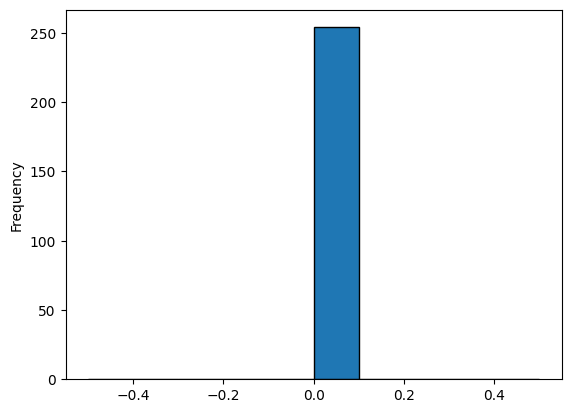

In [146]:
import matplotlib.pyplot as plt
data_series = pd.Series(count_nans)
data_series.plot(kind='hist', edgecolor='black')

plt.show()

Make a cutoff for only samples that have more than 1 cell of the type.

In [147]:
cutoff = pd.DataFrame(groups[groups > 1])
cutoff.groupby(cell_type_key).size()

/tmp/ipykernel_106/4030491492.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cutoff.groupby(cell_type_key).size()


cell_type_tumor
Alveolar cell type 1               254
Alveolar cell type 2               254
B cell                             254
B cell dividing                    254
Ciliated                           254
Club                               254
DC mature                          254
Endothelial cell arterial          254
Endothelial cell capillary         254
Endothelial cell lymphatic         254
Endothelial cell venous            254
Fibroblast adventitial             254
Fibroblast alveolar                254
Fibroblast peribronchial           254
Macrophage                         254
Macrophage alveolar                254
Mast cell                          254
Mesothelial                        254
Monocyte classical                 254
Monocyte non-classical             254
NK cell                            254
NK cell dividing                   254
Neutrophils                        254
Pericyte                           254
Plasma cell                        254
Plasma ce

### Cells by type

In [148]:
cutoff.groupby(cell_type_key).sum()

/tmp/ipykernel_106/1670320304.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cutoff.groupby(cell_type_key).sum()


,0
cell_type_tumor,
Alveolar cell type 1,659.0
Alveolar cell type 2,6970.0
B cell,41997.0
B cell dividing,297.0
Ciliated,3044.0
Club,880.0
DC mature,1034.0
Endothelial cell arterial,696.0
Endothelial cell capillary,2975.0


### Total cells:

In [149]:
cutoff.groupby(cell_type_key).sum().sum()

/tmp/ipykernel_106/3063716256.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cutoff.groupby(cell_type_key).sum().sum()


0    584099.0
dtype: float64

In [11]:
cutoff.groupby('Level_2_cancer').sum().sum()

0    902653.0
dtype: float64

### Matrix of Samples by type

Now to get the mutual information we need to have a matrix where 
we can get the pointwise mutual information (relative entropy) of any
two cell types 
$$
\log{\frac{p(x,y)}{p(x)p(y)}}
$$.
To then get the expected value of those:
$$
\sum_{X,Y}{p(x,y)\log{\frac{p(x,y)}{p(x)p(y)}}}
$$.

The idea was to get a discrete mutual information, because we are getting counts of cells being present in the tisse to study.
Nevertheless, a discrete mutual information would just be constraining the states to present or not present, or some
discrete states that would nevertheless be ordered and so the ranking that ARACNE does is indeed discrete.

Definitely just having present or not present would give us no info because at this level the clusters almost always have at least one cell.

In [12]:
groups

0
Level_2_cancer           sample                              
Airway epithelium_Normal P4_normal_adjacent_UKIM-V-2       56
                         P4_tumor_primary_UKIM-V-2         18
                         P5_normal_adjacent_UKIM-V-2       54
                         P5_tumor_primary_UKIM-V-2         33
                         P6_normal_adjacent_UKIM-V-2       22
...                                                       ...
Unknown_Tumor            NSCLC-7_Chen_Zhang_2020_NSCLC      0
                         NSCLC-8_Chen_Zhang_2020_NSCLC      0
                         NSCLC-9_Chen_Zhang_2020_NSCLC     27
                         NSCLC-10_Chen_Zhang_2020_NSCLC  1075
                         NSCLC-11_Chen_Zhang_2020_NSCLC     0

[4718 rows x 1 columns]

In [150]:
samp_type = groups.unstack().transpose()
samp_type

cell_type_tumor             Alveolar cell type 1  Alveolar cell type 2  \
  sample                                                                 
0 Chen_Zhang_2020_NSCLC-1                      0                     0   
  Chen_Zhang_2020_NSCLC-2                      0                     3   
  Chen_Zhang_2020_NSCLC-3                      0                     1   
  Chen_Zhang_2020_NSCLC-4                      0                     2   
  Chen_Zhang_2020_NSCLC-5                      1                     6   
...                                          ...                   ...   
  Zilionis_Klein_2019_p5t2                     0                     7   
  Zilionis_Klein_2019_p6t1                     0                    48   
  Zilionis_Klein_2019_p6t2                     0                    58   
  Zilionis_Klein_2019_p7t1                     0                    24   
  Zilionis_Klein_2019_p7t2                     0                    28   

cell_type_tumor             B cell  B cell dividing  Ciliated  Club  \
  sample                                                              
0 Chen_Zhang_2020_NSCLC-1      771                1         0     0   
  Chen_Zhang_2020_NSCLC-2      552                0         0     0   
  Chen_Zhang_2020_NSCLC-3      774                0         5     1   
  Chen_Zhang_2020_NSCLC-4      295                4         1     0   
  Chen_Zhang_2020_NSCLC-5     1572               42         4     3   
...                            ...              ...       ...   ...   
  Zilionis_Klein_2019_p5t2     320                0         3     0   
  Zilionis_Klein_2019_p6t1     314                2        10     3   
  Zilionis_Klein_2019_p6t2     272                0         7     2   
  Zilionis_Klein_2019_p7t1      39                0         0     0   
  Zilionis_Klein_2019_p7t2      37                0         0     0   

cell_type_tumor             DC mature  Endothelial cell arterial  \
  sample                                                           
0 Chen_Zhang_2020_NSCLC-1           1                         17   
  Chen_Zhang_2020_NSCLC-2           4                          1   
  Chen_Zhang_2020_NSCLC-3           5                          0   
  Chen_Zhang_2020_NSCLC-4           1                          0   
  Chen_Zhang_2020_NSCLC-5           5                          0   
...                               ...                        ...   
  Zilionis_Klein_2019_p5t2          2                          2   
  Zilionis_Klein_2019_p6t1          4                          3   
  Zilionis_Klein_2019_p6t2          2                          1   
  Zilionis_Klein_2019_p7t1          3                          0   
  Zilionis_Klein_2019_p7t2          6                          0   

cell_type_tumor             Endothelial cell capillary  \
  sample                                                 
0 Chen_Zhang_2020_NSCLC-1                           80   
  Chen_Zhang_2020_NSCLC-2                            1   
  Chen_Zhang_2020_NSCLC-3                            0   
  Chen_Zhang_2020_NSCLC-4                            0   
  Chen_Zhang_2020_NSCLC-5                            0   
...                                                ...   
  Zilionis_Klein_2019_p5t2                           5   
  Zilionis_Klein_2019_p6t1                           1   
  Zilionis_Klein_2019_p6t2                           2   
  Zilionis_Klein_2019_p7t1                           1   
  Zilionis_Klein_2019_p7t2                           0   

cell_type_tumor             Endothelial cell lymphatic  ...  \
  sample                                                ...   
0 Chen_Zhang_2020_NSCLC-1                            0  ...   
  Chen_Zhang_2020_NSCLC-2                            6  ...   
  Chen_Zhang_2020_NSCLC-3                            0  ...   
  Chen_Zhang_2020_NSCLC-4                            0  ...   
  Chen_Zhang_2020_NSCLC-5                            1  ...   
...                             

Checking below we see the submucosal gland cluster is rare so it wasn't projected by scArches.
This just means that effectively there are no cells with submocusal glands in that subset so we just replace them with zeros.

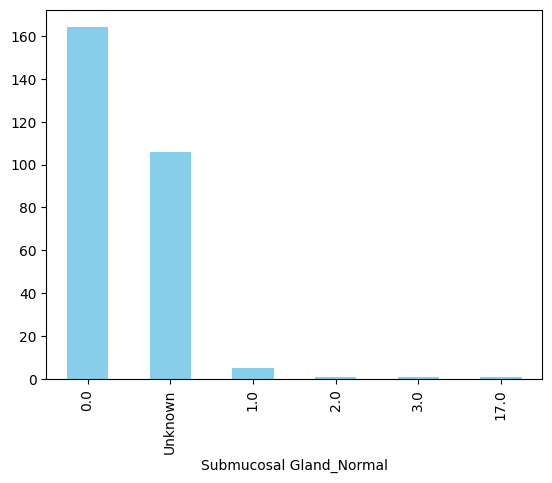

In [14]:
# Count the occurrences of each category
lol = samp_type['Submucosal Gland_Normal'].astype('category')
lol = lol.cat.add_categories('Unknown')
lol = lol.fillna('Unknown')

category_counts = lol.value_counts()

category_counts.plot(kind='bar', color='skyblue')
plt.show()

Most of it is 0's so we will remove that column. Also because our type annotation is very general,
we aren't getting very near to a limit of detection of our algorithm.
Though it would have to be related with our uncertainty.

In [17]:
del samp_type['Submucosal Gland_Normal']
del samp_type['Submucosal Gland_Tumor']

By the way the transfer of the labels is done in scArches, if the cluster is not present (*NA*) the label does not appear. So we replace NAs with 0s

In [16]:
samp_type = samp_type.fillna(0)
samp_type

Level_2_cancer                              Airway epithelium_Normal  \
  sample                                                               
0 1247_Lambrechts_2018_LUAD_6149v1                               1.0   
  BRONCHO_11_Kim_Lee_2020_LUAD                                  98.0   
  BRONCHO_58_Kim_Lee_2020_LUAD                                  28.0   
  BT1249_Lambrechts_2018_LUAD_6149v1                             0.0   
  BT1290_Lambrechts_2018_LUAD_6149v2                            23.0   
...                                                              ...   
  scrBT1428_hg19_Lambrechts_2018_LUAD_6653                      44.0   
  scrBT1429m_Lambrechts_2018_LUAD_6653                          26.0   
  scrBT1430m_Lambrechts_2018_LUAD_6653                           2.0   
  scrBT1431m_Lambrechts_2018_LUAD_6653                           2.0   
  scrBT1432m_Lambrechts_2018_LUAD_6653                           1.0   

Level_2_cancer                              Airway epithelium_Tumor  \
  sample                                                              
0 1247_Lambrechts_2018_LUAD_6149v1                              1.0   
  BRONCHO_11_Kim_Lee_2020_LUAD                                  1.0   
  BRONCHO_58_Kim_Lee_2020_LUAD                                  0.0   
  BT1249_Lambrechts_2018_LUAD_6149v1                           12.0   
  BT1290_Lambrechts_2018_LUAD_6149v2                           44.0   
...                                                             ...   
  scrBT1428_hg19_Lambrechts_2018_LUAD_6653                      0.0   
  scrBT1429m_Lambrechts_2018_LUAD_6653                          0.0   
  scrBT1430m_Lambrechts_2018_LUAD_6653                          7.0   
  scrBT1431m_Lambrechts_2018_LUAD_6653                          1.0   
  scrBT1432m_Lambrechts_2018_LUAD_6653                          1.0   

Level_2_cancer                              Alveolar epithelium_Normal  \
  sample                                                                 
0 1247_Lambrechts_2018_LUAD_6149v1                                70.0   
  BRONCHO_11_Kim_Lee_2020_LUAD                                     2.0   
  BRONCHO_58_Kim_Lee_2020_LUAD                                   307.0   
  BT1249_Lambrechts_2018_LUAD_6149v1                               0.0   
  BT1290_Lambrechts_2018_LUAD_6149v2                              18.0   
...                                                                ...   
  scrBT1428_hg19_Lambrechts_2018_LUAD_6653                       349.0   
  scrBT1429m_Lambrechts_2018_LUAD_6653                           204.0   
  scrBT1430m_Lambrechts_2018_LUAD_6653                            14.0   
  scrBT1431m_Lambrechts_2018_LUAD_6653                            36.0   
  scrBT1432m_Lambrechts_2018_LUAD_6653                             4.0   

Level_2_cancer                              Alveolar epithelium_Tumor  \
  sample                                                                
0 1247_Lambrechts_2018_LUAD_6149v1                                0.0   
  BRONCHO_11_Kim_Lee_2020_LUAD                                    0.0   
  BRONCHO_58_Kim_Lee_2020_LUAD                                    2.0   
  BT1249_Lambrechts_2018_LUAD_6149v1                              0.0   
  BT1290_Lambrechts_2018_LUAD_6149v2                            266.0   
...                                                               ...   
  scrBT1428_hg19_Lambrechts_2018_LUAD_6653                        0.0   
  scrBT1429m_Lambrechts_2018_LUAD_6653                            0.0   
  scrBT1430m_Lambrechts_2018_LUAD_6653                           29.0   
  scrBT1431m_Lambrechts_2018_LUAD_6653                            2.0   
  scrBT1432m_Lambrechts_2018_LUAD_6653                            1.0   

Level_2_cancer                              Blood vessels_Normal  \
  sample                                                           
0 1247_Lambrechts_2018_LUAD_6149v1                          31.0   
  BRONCHO_11_Kim_Lee_2

## Convert for correlation

We first convert to relative abundances with respect to the sample, to be able to compare.

In [27]:
corr_types = samp_type
corr_types = corr_types / corr_types.sum()

Then we transpose back to get the corr matrix

In [28]:
from scipy.stats import pearsonr, spearmanr
import numpy as np

data = corr_types.to_numpy().T
# Initialize matrices for correlation coefficients and p-values
n_variables = data.shape[0]  # Number of variables (rows in the original dataset)
pearson_matrix = np.zeros((n_variables, n_variables))
pearson_p_values = np.zeros((n_variables, n_variables))

# Compute pairwise correlations and p-values
for i in range(n_variables):
    for j in range(n_variables):
        if i == j:
            # The correlation of a variable with itself is always 1, and the p-value is 0
            pearson_matrix[i, j] = 1
            pearson_p_values[i, j] = 0
        elif i < j:
            # Compute correlation and p-value for unique pairs only
            correlation, p_value = pearsonr(data[i], data[j])
            pearson_matrix[i, j] = pearson_matrix[j, i] = correlation
            pearson_p_values[i, j] = pearson_p_values[j, i] = p_value
            
pd.DataFrame(pearson_matrix)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.000000,-0.024774,0.215186,-0.040088,0.098554,0.003890,0.106998,-0.023730,0.049432,-0.013920,0.024581,-0.019865,0.195846,0.339727,-0.006190,0.102691,0.005476,0.618435,-0.031144
1,-0.024774,1.000000,-0.058364,-0.003900,-0.036144,-0.002832,0.099351,0.166522,-0.043906,0.008642,-0.116169,0.177263,-0.032639,-0.076981,-0.016251,0.135640,0.437950,-0.054009,0.152764
2,0.215186,-0.058364,1.000000,0.035422,0.062969,0.020550,0.085041,-0.044055,0.036867,-0.012554,0.077021,-0.022074,0.137847,0.207985,-0.047628,0.012927,-0.032204,0.599679,-0.007880
3,-0.040088,-0.003900,0.035422,1.000000,-0.015031,0.006679,0.125713,0.229229,-0.032676,0.306677,0.137965,0.143396,-0.033984,-0.027594,-0.041193,0.111223,0.039114,-0.006185,0.703795
4,0.098554,-0.036144,0.062969,-0.015031,1.000000,0.717586,0.034383,-0.007488,0.474065,0.006833,-0.077093,-0.035645,0.016495,0.025726,-0.070184,0.038339,-0.013264,0.202354,-0.027646
5,0.003890,-0.002832,0.020550,0.006679,0.717586,1.000000,-0.019791,0.004191,-0.013898,0.008353,-0.040822,0.001512,-0.011479,-0.035747,-0.022910,-0.020220,-0.003616,0.131292,0.009642
6,0.106998,0.099351,0.085041,0.125713,0.034383,-0.019791,1.000000,0.226073,0.031396,0.081158,0.073779,0.314635,0.222093,0.182374,-0.011560,0.348005,0.014823,0.190062,0.064454
7,-0.023730,0.166522,-0.044055,0.229229,-0.007488,0.004191,0.226073,1.000000,-0.034441,0.159528,-0.088119,0.182403,-0.031058,-0.090985,0.029606,0.393945,-0.023096,-0.014867,0.291820
8,0.049432,-0.043906,0.036867,-0.032676,0.474065,-0.013898,0.031396,-0.034441,1.000000,-0.016383,-0.069117,-0.047756,0.057846,0.082684,-0.069256,0.029767,-0.015664,0.067619,-0.049561
9,-0.013920,0.008642,-0.012554,0.306677,0.006833,0.008353,0.081158,0.159528,-0.016383,1.000000,0.042952,0.074784,0.000062,0.004845,0.174089,0.022841,0.189919,-0.031051,0.234331


In [29]:
# pearson_df = 
pearson_df = pd.DataFrame(pearson_matrix, columns=samp_type.columns, index=samp_type.columns)
pearson_p_values_df = pd.DataFrame(pearson_p_values, columns=samp_type.columns, index=samp_type.columns)

In [32]:
pearson_p_values_df

Level_2_cancer,Airway epithelium_Normal,Airway epithelium_Tumor,Alveolar epithelium_Normal,Alveolar epithelium_Tumor,Blood vessels_Normal,Blood vessels_Tumor,Fibroblast lineage_Normal,Fibroblast lineage_Tumor,Lymphatic EC_Normal,Lymphatic EC_Tumor,Lymphoid_Normal,Lymphoid_Tumor,Mesothelium_Normal,Myeloid_Normal,Myeloid_Tumor,Smooth muscle_Normal,Smooth muscle_Tumor,Unknown_Normal,Unknown_Tumor
Level_2_cancer,,,,,,,,,,,,,,,,,,,
Airway epithelium_Normal,0.000000e+00,6.808801e-01,3.013565e-04,5.056290e-01,1.010436e-01,9.485192e-01,7.489726e-02,6.936376e-01,4.116509e-01,8.172753e-01,6.832288e-01,7.415857e-01,1.028746e-03,6.148868e-09,0.918160,8.744965e-02,9.275841e-01,9.973866e-31,6.051096e-01
Airway epithelium_Tumor,6.808801e-01,0.000000e+00,3.322625e-01,9.483919e-01,5.484234e-01,9.625147e-01,9.830186e-02,5.378893e-03,4.659337e-01,8.859342e-01,5.302011e-02,3.019184e-03,5.878956e-01,2.006717e-01,0.787345,2.370741e-02,1.865907e-14,3.696594e-01,1.075399e-02
Alveolar epithelium_Normal,3.013565e-04,3.322625e-01,0.000000e+00,5.564444e-01,2.954646e-01,7.330074e-01,1.573337e-01,4.644158e-01,5.404440e-01,8.349258e-01,2.004360e-01,7.140386e-01,2.150549e-02,4.822498e-04,0.428952,8.300983e-01,5.928788e-01,1.546441e-28,8.959377e-01
Alveolar epithelium_Tumor,5.056290e-01,9.483919e-01,5.564444e-01,0.000000e+00,8.029691e-01,9.117326e-01,3.617777e-02,1.151327e-04,5.874647e-01,1.823055e-07,2.139199e-02,1.673395e-02,5.725986e-01,6.468842e-01,0.493959,6.404726e-02,5.160380e-01,9.182281e-01,7.036953e-43
Blood vessels_Normal,1.010436e-01,5.484234e-01,2.954646e-01,8.029691e-01,0.000000e+00,2.915776e-45,5.680940e-01,9.010799e-01,5.545718e-17,9.097010e-01,2.000152e-01,5.539644e-01,7.842310e-01,6.693290e-01,0.243466,5.243933e-01,8.257452e-01,6.890767e-04,6.462566e-01
Blood vessels_Tumor,9.485192e-01,9.625147e-01,7.330074e-01,9.117326e-01,2.915776e-45,0.000000e+00,7.425146e-01,9.445407e-01,8.175545e-01,8.897253e-01,4.978629e-01,9.799762e-01,8.488897e-01,5.528308e-01,0.703708,7.371321e-01,9.521451e-01,2.861900e-02,8.728442e-01
Fibroblast lineage_Normal,7.489726e-02,9.830186e-02,1.573337e-01,3.617777e-02,5.680940e-01,7.425146e-01,0.000000e+00,1.436842e-04,6.021930e-01,1.772391e-01,2.200967e-01,8.364154e-08,1.891515e-04,2.267756e-03,0.847831,2.465942e-09,8.056461e-01,1.453745e-03,2.842004e-01
Fibroblast lineage_Tumor,6.936376e-01,5.378893e-03,4.644158e-01,1.151327e-04,9.010799e-01,9.445407e-01,1.436842e-04,0.000000e+00,5.674400e-01,7.699506e-03,1.427916e-01,2.264070e-03,6.061169e-01,1.301960e-01,0.623065,9.333992e-12,7.014197e-01,8.050783e-01,7.349828e-07
Lymphatic EC_Normal,4.116509e-01,4.659337e-01,5.404440e-01,5.874647e-01,5.545718e-17,8.175545e-01,6.021930e-01,5.674400e-01,0.000000e+00,7.856685e-01,2.507217e-01,4.277124e-01,3.365811e-01,1.692062e-01,0.249770,6.211775e-01,7.948603e-01,2.611634e-01,4.104297e-01


In [33]:
pearson_df

Level_2_cancer,Airway epithelium_Normal,Airway epithelium_Tumor,Alveolar epithelium_Normal,Alveolar epithelium_Tumor,Blood vessels_Normal,Blood vessels_Tumor,Fibroblast lineage_Normal,Fibroblast lineage_Tumor,Lymphatic EC_Normal,Lymphatic EC_Tumor,Lymphoid_Normal,Lymphoid_Tumor,Mesothelium_Normal,Myeloid_Normal,Myeloid_Tumor,Smooth muscle_Normal,Smooth muscle_Tumor,Unknown_Normal,Unknown_Tumor
Level_2_cancer,,,,,,,,,,,,,,,,,,,
Airway epithelium_Normal,1.000000,-0.024774,0.215186,-0.040088,0.098554,0.003890,0.106998,-0.023730,0.049432,-0.013920,0.024581,-0.019865,0.195846,0.339727,-0.006190,0.102691,0.005476,0.618435,-0.031144
Airway epithelium_Tumor,-0.024774,1.000000,-0.058364,-0.003900,-0.036144,-0.002832,0.099351,0.166522,-0.043906,0.008642,-0.116169,0.177263,-0.032639,-0.076981,-0.016251,0.135640,0.437950,-0.054009,0.152764
Alveolar epithelium_Normal,0.215186,-0.058364,1.000000,0.035422,0.062969,0.020550,0.085041,-0.044055,0.036867,-0.012554,0.077021,-0.022074,0.137847,0.207985,-0.047628,0.012927,-0.032204,0.599679,-0.007880
Alveolar epithelium_Tumor,-0.040088,-0.003900,0.035422,1.000000,-0.015031,0.006679,0.125713,0.229229,-0.032676,0.306677,0.137965,0.143396,-0.033984,-0.027594,-0.041193,0.111223,0.039114,-0.006185,0.703795
Blood vessels_Normal,0.098554,-0.036144,0.062969,-0.015031,1.000000,0.717586,0.034383,-0.007488,0.474065,0.006833,-0.077093,-0.035645,0.016495,0.025726,-0.070184,0.038339,-0.013264,0.202354,-0.027646
Blood vessels_Tumor,0.003890,-0.002832,0.020550,0.006679,0.717586,1.000000,-0.019791,0.004191,-0.013898,0.008353,-0.040822,0.001512,-0.011479,-0.035747,-0.022910,-0.020220,-0.003616,0.131292,0.009642
Fibroblast lineage_Normal,0.106998,0.099351,0.085041,0.125713,0.034383,-0.019791,1.000000,0.226073,0.031396,0.081158,0.073779,0.314635,0.222093,0.182374,-0.011560,0.348005,0.014823,0.190062,0.064454
Fibroblast lineage_Tumor,-0.023730,0.166522,-0.044055,0.229229,-0.007488,0.004191,0.226073,1.000000,-0.034441,0.159528,-0.088119,0.182403,-0.031058,-0.090985,0.029606,0.393945,-0.023096,-0.014867,0.291820
Lymphatic EC_Normal,0.049432,-0.043906,0.036867,-0.032676,0.474065,-0.013898,0.031396,-0.034441,1.000000,-0.016383,-0.069117,-0.047756,0.057846,0.082684,-0.069256,0.029767,-0.015664,0.067619,-0.049561


We also get the spearman matrix

In [34]:
data = corr_types.to_numpy().T
# Initialize matrices for correlation coefficients and p-values
n_variables = data.shape[0]  # Number of variables (rows in the original dataset)
spearman_matrix = np.zeros((n_variables, n_variables))
spearman_p_values = np.zeros((n_variables, n_variables))

# Compute pairwise correlations and p-values
for i in range(n_variables):
    for j in range(n_variables):
        if i == j:
            # The correlation of a variable with itself is always 1, and the p-value is 0
            spearman_matrix[i, j] = 1
            spearman_p_values[i, j] = 0
        elif i < j:
            # Compute correlation and p-value for unique pairs only
            correlation, p_value = spearmanr(data[i], data[j])
            spearman_matrix[i, j] = spearman_matrix[j, i] = correlation
            spearman_p_values[i, j] = spearman_p_values[j, i] = p_value
            
pd.DataFrame(spearman_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.000000,0.054448,0.430467,0.043169,0.387621,0.045975,0.263220,-0.029734,0.212545,0.012355,0.169699,0.064092,0.212845,0.359428,0.081242,0.243884,0.071425,0.650183,0.015920
1,0.054448,1.000000,-0.287504,0.387801,-0.035155,0.388660,0.141229,0.238126,-0.232031,0.148540,-0.266308,0.641425,-0.100191,-0.205349,0.469559,0.020559,0.195823,-0.004579,0.808547
2,0.430467,-0.287504,1.000000,0.133900,0.481247,-0.123077,0.282848,-0.137876,0.403562,0.033851,0.384747,-0.192019,0.228046,0.588502,-0.243445,0.265683,-0.095121,0.489141,-0.191959
3,0.043169,0.387801,0.133900,1.000000,0.041001,0.239426,0.092131,0.133212,-0.006224,0.242215,0.080991,0.290254,0.015426,0.056027,0.176506,0.111138,0.144931,0.164954,0.610825
4,0.387621,-0.035155,0.481247,0.041001,1.000000,0.169632,0.667336,0.182221,0.643935,0.175514,0.249390,-0.007487,0.231192,0.523796,-0.089794,0.609171,0.069314,0.415279,-0.025033
5,0.045975,0.388660,-0.123077,0.239426,0.169632,1.000000,0.195027,0.267114,0.004726,0.188683,-0.095459,0.427431,0.073536,-0.148281,0.272041,0.110386,0.228920,0.026606,0.388416
6,0.263220,0.141229,0.282848,0.092131,0.667336,0.195027,1.000000,0.185717,0.436836,0.119387,0.165068,0.107699,0.182425,0.350715,-0.039531,0.682024,0.094609,0.364135,0.140309
7,-0.029734,0.238126,-0.137876,0.133212,0.182221,0.267114,0.185717,1.000000,0.010798,0.210686,-0.110061,0.244368,-0.044474,-0.125619,0.226060,0.194642,-0.025656,0.119771,0.283049
8,0.212545,-0.232031,0.403562,-0.006224,0.643935,0.004726,0.436836,0.010798,1.000000,0.150183,0.441999,-0.172890,0.281277,0.550776,-0.188612,0.368443,0.026065,0.215840,-0.211817
9,0.012355,0.148540,0.033851,0.242215,0.175514,0.188683,0.119387,0.210686,0.150183,1.000000,0.080816,0.155066,0.011141,0.065396,0.044383,0.070859,0.189919,0.053060,0.179529


In [60]:
spearman_df = pd.DataFrame(spearman_matrix, columns=samp_type.columns, index=samp_type.columns)
spearman_p_values_df = pd.DataFrame(spearman_p_values, columns=samp_type.columns, index=samp_type.columns)

### Convert to graph

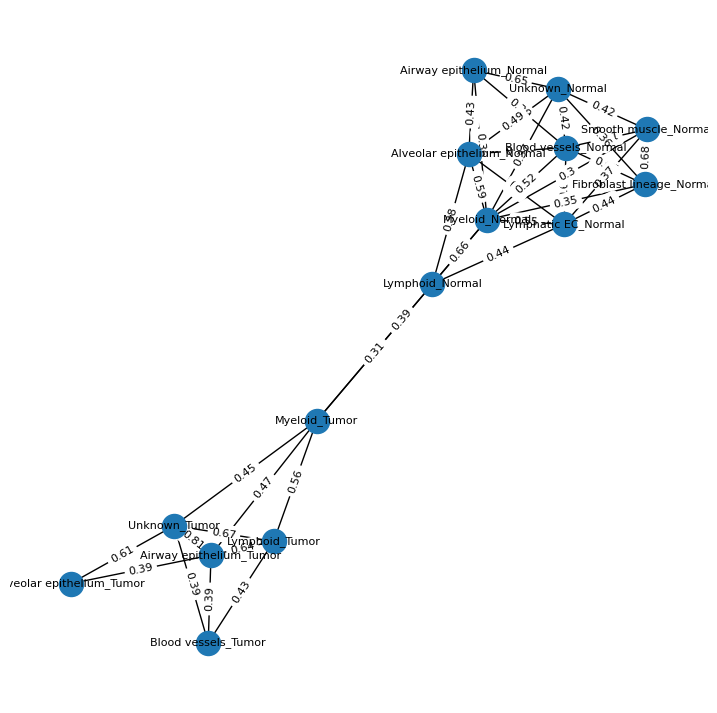

In [105]:
import networkx as nx
# Create a graph from the correlation DataFrame
G = nx.Graph()

# Add edges between all nodes with correlation as edge attribute
for col1 in spearman_df.columns:
    for col2 in spearman_df.index:
        if col1 != col2:
            # Add an edge between col1 and col2 with the correlation as an attribute
            G.add_edge(col1, col2, weight=abs(round(spearman_df.loc[col1, col2],2)))

# Remove edges with very low correlation and high p-value
threshold = 0.3
threshold_p = 0.05
for (u, v, d) in list(G.edges(data=True)):
    if abs(d['weight']) < threshold or abs(spearman_p_values_df.loc[u, v]) > threshold_p:
        G.remove_edge(u, v)

# Remove all nodes with no edges
nodes_with_no_edges = [node for node, degree in G.degree() if degree == 0]
G.remove_nodes_from(nodes_with_no_edges)

plt.figure(figsize=(9, 9))  # Increase figure size
pos = nx.spring_layout(G, )  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=300)

# edges
nx.draw_networkx_edges(G, pos, width=1.0)

# labels
nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")

# edge labels
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.axis('off')  # Turn off the axis
plt.show()

In [106]:
G_spear = G

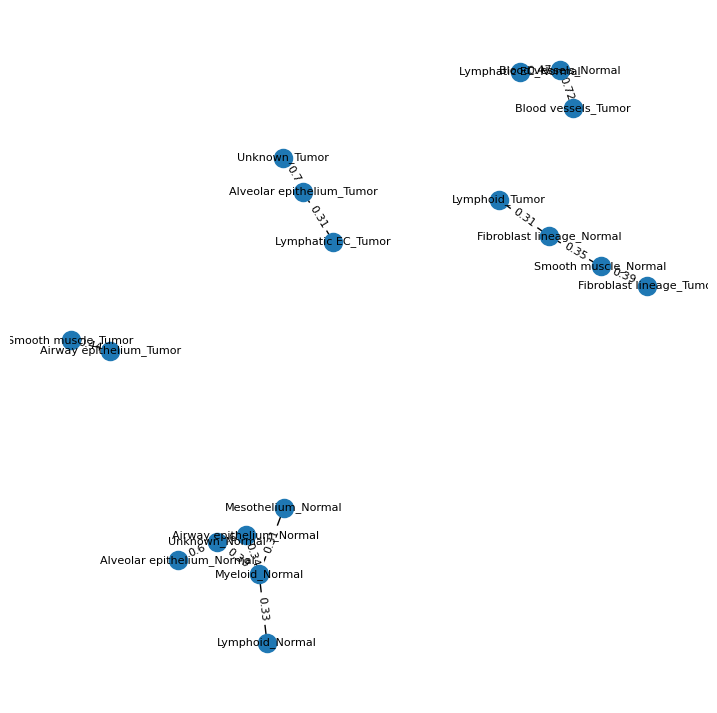

In [101]:
import networkx as nx
# Create a graph from the correlation DataFrame
G = nx.Graph()

# Add edges between all nodes with correlation as edge attribute
for col1 in pearson_df.columns:
    for col2 in pearson_df.index:
        if col1 != col2:
            # Add an edge between col1 and col2 with the correlation as an attribute
            G.add_edge(col1, col2, weight=(round(pearson_df.loc[col1, col2],2)))

# Remove edges with very low correlation and high p-value
threshold = 0.3 
threshold_p = 0.05
for (u, v, d) in list(G.edges(data=True)):
    if abs(d['weight']) < threshold or abs(pearson_p_values_df.loc[u, v]) > threshold_p:
        G.remove_edge(u, v)

# Remove all nodes with no edges
nodes_with_no_edges = [node for node, degree in G.degree() if degree == 0]
G.remove_nodes_from(nodes_with_no_edges)

plt.figure(figsize=(9, 9))  # Increase figure size
pos = nx.spring_layout(G, )  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=170)

# edges
nx.draw_networkx_edges(G, pos, width=1.0)

# labels
nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")

# edge labels
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.axis('off')  # Turn off the axis
plt.show()

In [84]:
G_pear = G

## Calcualte MI with ARACNE AP

We export in a format that can be used for ARACNE AP, which has the 'genes' in the rows and only considers Target/TF pairs.
We repeat each type row because every type is a TF and a target.

In [151]:
aracne_types = samp_type.transpose()

# Repeat to force ARACNE to consider types as target and TF.
aracne_types = pd.concat([aracne_types, aracne_types])

aracne_types.astype(int)
aracne_types.columns.name = None
aracne_types.index.name = 'genes'
aracne_types

0                          \
sample                Chen_Zhang_2020_NSCLC-1 Chen_Zhang_2020_NSCLC-2   
genes                                                                   
Alveolar cell type 1                        0                       0   
Alveolar cell type 2                        0                       3   
B cell                                    771                     552   
B cell dividing                             1                       0   
Ciliated                                    0                       0   
...                                       ...                     ...   
cDC2                                        7                      45   
myeloid dividing                            0                       3   
pDC                                         5                       7   
stromal dividing                            0                       1   
transitional club/AT2                      15                      65   

                                                                       \
sample                Chen_Zhang_2020_NSCLC-3 Chen_Zhang_2020_NSCLC-4   
genes                                                                   
Alveolar cell type 1                        0                       0   
Alveolar cell type 2                        1                       2   
B cell                                    774                     295   
B cell dividing                             0                       4   
Ciliated                                    5                       1   
...                                       ...                     ...   
cDC2                                       25                       8   
myeloid dividing                            2                       1   
pDC                                        35                       3   
stromal dividing                            0                       1   
transitional club/AT2                      12                       5   

                                                                       \
sample                Chen_Zhang_2020_NSCLC-5 Chen_Zhang_2020_NSCLC-6   
genes                                                                   
Alveolar cell type 1                        1                      45   
Alveolar cell type 2                        6                     135   
B cell                                   1572                     119   
B cell dividing                            42                       0   
Ciliated                                    4                      41   
...                                       ...                     ...   
cDC2                                       30                     596   
myeloid dividing                            2                     135   
pDC                                        14                       9   
stromal dividing                            0                       0   
transitional club/AT2                       7                      64   

                                                                       \
sample                Chen_Zhang_2020_NSCLC-7 Chen_Zhang_2020_NSCLC-8   
genes                                                                   
Alveolar cell type 1                        0                      53   
Alveolar cell type 2                        0                     350   
B cell                                   1841                     147   
B cell dividing                             4                       0   
Ciliated                                    0                      61   
...                                       ...                     ...   
cDC2                                       78                    1128   
myeloid dividing                            7                     212   
pDC                                        21                       6   
stromal dividing                            4                       0   
transitional club/AT2     

In [247]:
aracne_types.index

Index(['Airway epithelium_Normal', 'Airway epithelium_Tumor',
       'Alveolar epithelium_Normal', 'Alveolar epithelium_Tumor',
       'Blood vessels_Normal', 'Blood vessels_Tumor',
       'Fibroblast lineage_Normal', 'Fibroblast lineage_Tumor',
       'Lymphatic EC_Normal', 'Lymphatic EC_Tumor', 'Lymphoid_Normal',
       'Lymphoid_Tumor', 'Mesothelium_Normal', 'Myeloid_Normal',
       'Myeloid_Tumor', 'Smooth muscle_Normal', 'Smooth muscle_Tumor',
       'Unknown_Normal', 'Unknown_Tumor', 'Airway epithelium_Normal',
       'Airway epithelium_Tumor', 'Alveolar epithelium_Normal',
       'Alveolar epithelium_Tumor', 'Blood vessels_Normal',
       'Blood vessels_Tumor', 'Fibroblast lineage_Normal',
       'Fibroblast lineage_Tumor', 'Lymphatic EC_Normal', 'Lymphatic EC_Tumor',
       'Lymphoid_Normal', 'Lymphoid_Tumor', 'Mesothelium_Normal',
       'Myeloid_Normal', 'Myeloid_Tumor', 'Smooth muscle_Normal',
       'Smooth muscle_Tumor', 'Unknown_Normal', 'Unknown_Tumor'],
      dtype='obj

In [152]:
tfs = aracne_types.index[0:int(aracne_types.shape[0]/2)]

with open('tfs.txt', 'w') as f:
    for tf in tfs:
        f.write(str(tf) + '\n')

In [133]:
! cat tfs.txt

1861907.60s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Alveolar cell type 1
Alveolar cell type 2
B cell
B cell dividing
Ciliated
Club
DC mature
Endothelial cell arterial
Endothelial cell capillary
Endothelial cell lymphatic
Endothelial cell venous
Fibroblast adventitial
Fibroblast alveolar
Fibroblast peribronchial
Macrophage
Macrophage alveolar
Mast cell
Mesothelial
Monocyte classical
Monocyte non-classical
NK cell
NK cell dividing
Neutrophils
Pericyte
Plasma cell
Plasma cell dividing
ROS1+ healthy epithelial
Smooth muscle cell
T cell CD4
T cell CD4 dividing
T cell CD8 activated
T cell CD8 dividing
T cell CD8 effector memory
T cell CD8 naive
T cell CD8 terminally exhausted
T cell NK-like
T cell regulatory
Tumor cells LUAD
Tumor cells LUAD EMT
Tumor cells LUAD MSLN
Tumor cells LUAD NE
Tumor cells LUAD mitotic
Tumor cells LUSC
Tumor cells LUSC mitotic
Tumor cells NSCLC mixed
cDC1
cDC2
myeloid dividing
pDC
stromal dividing
transitional club/AT2


In [153]:
a = aracne_types.reset_index()
a.columns = a.columns.get_level_values('sample')
a = a.set_index([''])

In [154]:
a.to_csv('matrix.txt', sep='\t')

In [136]:
! head matrix.txt

1861926.82s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
	Adams_Kaminski_2020_001C	Adams_Kaminski_2020_002C	Adams_Kaminski_2020_003C	Adams_Kaminski_2020_8CO	Adams_Kaminski_2020_022C-a	Adams_Kaminski_2020_022C-b	Adams_Kaminski_2020_23CO	Adams_Kaminski_2020_034C	Adams_Kaminski_2020_052CO-a	Adams_Kaminski_2020_056CO	Adams_Kaminski_2020_065C	Adams_Kaminski_2020_081C	Adams_Kaminski_2020_084C	Adams_Kaminski_2020_092C	Adams_Kaminski_2020_92C	Adams_Kaminski_2020_098C-a	Adams_Kaminski_2020_098C-b	Adams_Kaminski_2020_133C-a	Adams_Kaminski_2020_137C	Adams_Kaminski_2020_137C-a	Adams_Kaminski_2020_137C-b	Adams_Kaminski_2020_137CO	Adams_Kaminski_2020_152CO	Adams_Kaminski_2020_152CO-a	Adams_Kaminski_2020_153CO-a	Adams_Kaminski_2020_153CO-b	Adams_Kaminski_2020_160C	Adams_Kaminski_2020_178CO	Adams_Kaminski_2020_184CO-a	Adams_Kaminski_2020_184CO-b	Adams_Kaminski_2020_186CO-b	Adams_Kaminski_2020_192C-a	Adams_Kaminski_2020_192CO	Adams_Kaminski_2020_192CO-a	Adams_Ka

We use [ARACNE-AP](https://github.com/califano-lab/ARACNe-AP/tree/master) because it is fast 
and we dont need many libraries. Just JAVA. Downlaod the git repo and change the path to that.

First we must calculate the threshold

In [155]:
! java -Xmx5G -jar /root/host_home/ARACNe-AP/dist/aracne.jar -e matrix.txt  -o outputARACNE \
    --tfs tfs.txt --pvalue 1E-8 --seed 1 --nobootstrap --nodpi \
    --calculateThreshold

1862608.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
MI threshold file was already there, but I am recalculating it.
Finding threshold for 254 samples
Parameters for fitted threshold function: [0.09672301068900926, 6.225412313445222E-6]
MI threshold: 0.11170910262715995


In [156]:
%%time
! java -Xmx5G -jar /root/host_home/ARACNe-AP/dist/aracne.jar -e matrix.txt  -o outputARACNE \
    --tfs tfs.txt --pvalue 1E-8 --seed 1 --nobootstrap --nodpi

1862657.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
MI threshold file is present
Calculate network from: matrix.txt
TFs processed: 51
Time elapsed for calculating MI: 0 sec

Edges removed by DPI:	0
Final Network size:	806
Total time elapsed: 0 sec
CPU times: user 0 ns, sys: 1.78 s, total: 1.78 s
Wall time: 8.26 s


In [157]:
! sed '1d' outputARACNE/nobootstrap_network.txt > outputARACNE/net_ext.txt

1862665.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [158]:
! cat outputARACNE/net_ext.txt

1862673.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Fibroblast peribronchial	Fibroblast alveolar	0.16102125662190225
Fibroblast peribronchial	Smooth muscle cell	0.1591264263151837
Fibroblast peribronchial	Tumor cells LUSC mitotic	0.1483261722270246
Fibroblast peribronchial	Pericyte	0.32779641056288167
Fibroblast peribronchial	Tumor cells LUSC	0.11772605012017312
Fibroblast peribronchial	Plasma cell	0.17077364579534304
Fibroblast peribronchial	Endothelial cell venous	0.23596091253017626
Fibroblast peribronchial	Tumor cells LUAD mitotic	0.11299493821923257
Fibroblast peribronchial	stromal dividing	0.13225670110997712
Fibroblast peribronchial	Fibroblast adventitial	0.24515719984057593
Fibroblast peribronchial	Monocyte classical	0.18384482178929584
Fibroblast peribronchial	B cell	0.12804875685501038
Fibroblast peribronchial	Macrophage alveolar	0.12251923374177576
Fibroblast peribronchial	Tumor cells LUAD	0.2323439816975208
Fibroblast peribronch

### Paint MI network

In [159]:
import numpy as np
import pandas as pd

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

import matplotlib.pyplot as plt

from utils.functions import functional_network_plot




In [58]:
import utils.functions as ut
import importlib

importlib.reload(ut)

<module 'utils.functions' from '/root/host_home/luca/utils/functions.py'>

In [160]:
G = nx.read_edgelist("outputARACNE/net_ext.txt", data=(("MI", str),), delimiter='\t')
list(G.edges(data=True))

[('Fibroblast peribronchial',
  'Fibroblast alveolar',
  {'MI': '0.19820619970469977'}),
 ('Fibroblast peribronchial',
  'Smooth muscle cell',
  {'MI': '0.1871438758111239'}),
 ('Fibroblast peribronchial',
  'Tumor cells LUSC mitotic',
  {'MI': '0.18359146874795584'}),
 ('Fibroblast peribronchial', 'Pericyte', {'MI': '0.32016009878794893'}),
 ('Fibroblast peribronchial',
  'Tumor cells LUSC',
  {'MI': '0.12162333206216314'}),
 ('Fibroblast peribronchial', 'Plasma cell', {'MI': '0.1853115614986507'}),
 ('Fibroblast peribronchial',
  'Endothelial cell venous',
  {'MI': '0.2780717355027793'}),
 ('Fibroblast peribronchial',
  'Tumor cells LUAD mitotic',
  {'MI': '0.11299493821923257'}),
 ('Fibroblast peribronchial',
  'stromal dividing',
  {'MI': '0.16308811843525994'}),
 ('Fibroblast peribronchial',
  'Fibroblast adventitial',
  {'MI': '0.22517699118615297'}),
 ('Fibroblast peribronchial',
  'Monocyte classical',
  {'MI': '0.17788028589276283'}),
 ('Fibroblast peribronchial', 'B cell', {'

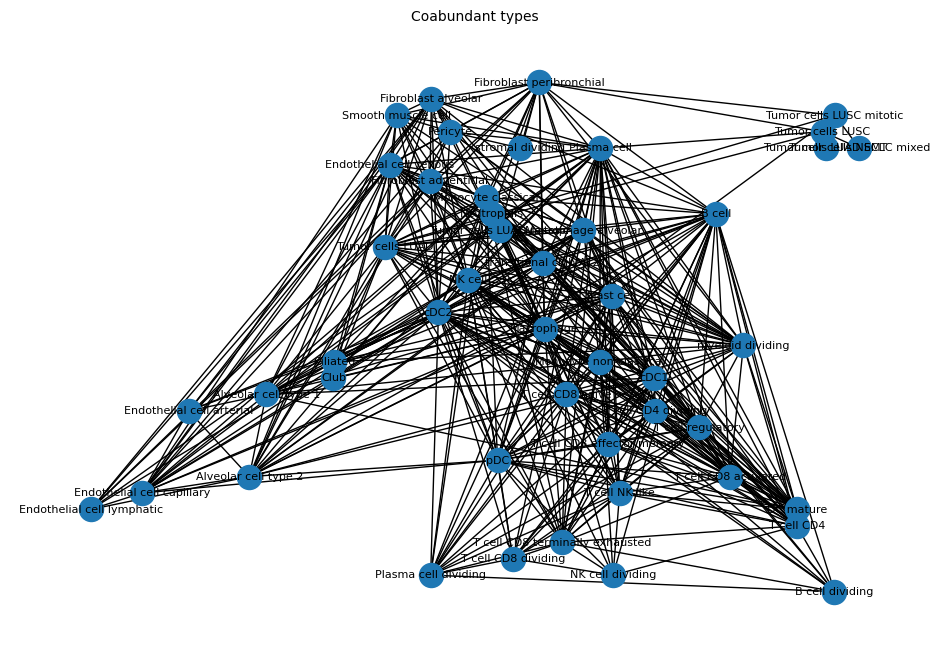

In [161]:
plt.figure(figsize=(12, 8))  # Set a larger figure size (width, height in inches)
plt.title('Coabundant types', fontsize=10)  # Smaller title font size

pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True, font_size=8)  # Smaller label font size
plt.savefig('coabundant_types_ext.png')

In [162]:
G_MI = G

In [357]:
G = nx.read_edgelist("outputARACNE/net_no_cancer.txt", data=(("MI", str),), delimiter='\t')
list(G.edges(data=True))

[('Lymphatic EC', 'Blood vessels', {'MI': '0.28237782131520817'}),
 ('Lymphatic EC', 'Myeloid', {'MI': '0.1125293287963105'}),
 ('Blood vessels', 'Smooth muscle', {'MI': '0.2081188843891475'}),
 ('Blood vessels', 'Myeloid', {'MI': '0.17572637686214776'}),
 ('Blood vessels', 'Fibroblast lineage', {'MI': '0.29667128232006323'}),
 ('Myeloid', 'Lymphoid', {'MI': '0.17747374716515907'}),
 ('Myeloid', 'Alveolar epithelium', {'MI': '0.12418377909800515'}),
 ('Lymphoid', 'Alveolar epithelium', {'MI': '0.11453408820865185'}),
 ('Alveolar epithelium', 'Unknown', {'MI': '0.13703129801696612'}),
 ('Alveolar epithelium', 'Airway epithelium', {'MI': '0.11947828749822431'}),
 ('Unknown', 'Airway epithelium', {'MI': '0.23103608471959003'}),
 ('Smooth muscle', 'Fibroblast lineage', {'MI': '0.26457154237473635'})]

In [372]:
G.nodes['Myeloid']['color'] = 'blue'
G.nodes['Lymphoid']['color'] = 'blue'
G.nodes['Lymphatic EC']['color'] = 'blue'
G.nodes['Alveolar epithelium']['color'] = 'purple'
G.nodes['Airway epithelium']['color'] = 'purple'
--
G.nodes['Blood vessels']['color'] = 'red'
G.nodes['Smooth muscle']['color'] = 'red'
G.nodes['Fibroblast lineage']['color'] = 'green'
G.nodes['Unknown']['color'] = 'black'


In [374]:
G.nodes['Unknown']

{'black': 'black', 'color': 'black'}

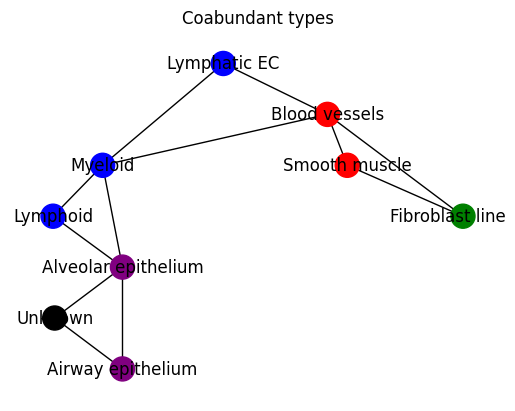

In [375]:
plt.title('Coabundant types')
pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True, node_color=[G.nodes[node]['color'] for node in G.nodes()])
plt.savefig('coabundant_types2.png')

Maybe we can do also mututal information of samples and see if clusters correlate with cancer or tissue type

## Compare correlation measures

Reorder the edge list to have lexicographic order in the pairs to be ale to substract the edges. And see which edges are new.

In [98]:
mi_edges = list(G_MI.edges)
mi_edges_order = [(b, a) if a < b else (a, b) for a, b in mi_edges]

spear_edges = list(G_spear.edges)
spear_edges_order = [(b, a) if a < b else (a, b) for a, b in spear_edges]

pear_edges = list(G_pear.edges)
pear_edges_order = [(b, a) if a < b else (a, b) for a, b in pear_edges]

In [100]:
set(spear_edges_order) - set(mi_edges_order)

{('Alveolar epithelium_Tumor', 'Airway epithelium_Tumor'),
 ('Blood vessels_Normal', 'Airway epithelium_Normal'),
 ('Blood vessels_Tumor', 'Airway epithelium_Tumor'),
 ('Lymphatic EC_Normal', 'Alveolar epithelium_Normal'),
 ('Lymphatic EC_Normal', 'Fibroblast lineage_Normal'),
 ('Lymphoid_Tumor', 'Blood vessels_Tumor'),
 ('Myeloid_Normal', 'Fibroblast lineage_Normal'),
 ('Myeloid_Tumor', 'Lymphoid_Normal'),
 ('Smooth muscle_Normal', 'Lymphatic EC_Normal'),
 ('Smooth muscle_Normal', 'Myeloid_Normal'),
 ('Unknown_Normal', 'Fibroblast lineage_Normal')}

We do a scatterplot of the differing edges.

## Functional Enrichment

To do a functional enrichment of the nodes in the network we can use the enrichment score from a GSEA run, on different hallmarks. For example the cancer Hallmarks.
To do this we can use the **NES**'s (normalized enrichment scores) for every study. 

This score is divided by the mean **ES** that would arise from all permutations of the gene set in question,
so as to be comparable with other gene sets. If it is $>1$ it is overexpressed, and if it is $<-1$ it is downregulated.

Due to the normalization we can do a mean of the **NES** in different studies to express a central notion of how expressed a gene set is.
We would also have to mind the FDR adjusted p-value to actually be on te sure side.

Let's procceed to massage the heatmap tables for our purposes.

In [43]:
heatmap_dir = 'nb_tumorUMAP/gseapy_gsea'

dsets = pd.read_csv('dsets.csv')
# dsets = dsets[lambda x: x['id'] != 'Zilionis_Klein_2019_NSCLC']
heatmaps = None
for i, id_ in enumerate(dsets.id):
    heatmap_path = f'{heatmap_dir}/heatmap_{id_}.csv'
    heatmap = pd.read_csv(heatmap_path)
    heatmap['id'] = id_
    heatmaps = pd.concat([heatmaps, heatmap]) if i != 0 else heatmap
# Pull the id column to the front
temp_cols=heatmaps.columns.tolist()
new_cols=temp_cols[-1:] + temp_cols[:-1]
heatmaps=heatmaps[new_cols]

# Function to extract and concatenate the 2nd and 4th elements after splitting
def concat_elements(s):
    parts = s.split('_')
    # Concatenate 2nd and 4th elements if they exist
    return parts[0] + '_' + parts[2] if len(parts) > 2 else None

heatmaps['cell_type'] = heatmaps['cell_type'].apply(concat_elements)

heatmaps
    

,id,cell_type,ADIPOGENESIS,ALLOGRAFT_REJECTION,ANDROGEN_RESPONSE,ANGIOGENESIS,APICAL_JUNCTION,APICAL_SURFACE,APOPTOSIS,BILE_ACID_METABOLISM,...,PROTEIN_SECRETION,REACTIVE_OXYGEN_SPECIES_PATHWAY,SPERMATOGENESIS,TGF_BETA_SIGNALING,TNFA_SIGNALING_VIA_NFKB,UNFOLDED_PROTEIN_RESPONSE,UV_RESPONSE_DN,UV_RESPONSE_UP,WNT_BETA_CATENIN_SIGNALING,XENOBIOTIC_METABOLISM
0,Chen_Zhang_2020_NSCLC,Airway epithelium_Tumor,1.188678,-1.000000,1.140886,0.875721,1.071825,0.859788,1.062186,1.166433,...,1.351801,1.151056,1.052564,0.882200,-1.000000,1.168615,1.227359,1.099518,1.036979,1.201464
1,Chen_Zhang_2020_NSCLC,Alveolar epithelium_Tumor,1.394299,-1.000000,1.245062,-0.839609,0.993117,0.765954,0.922926,1.346989,...,1.395775,1.129111,1.071952,0.710404,-1.749738,0.971467,1.218559,1.031066,0.771597,1.412434
2,Chen_Zhang_2020_NSCLC,Blood vessels_Tumor,-0.998238,-1.527725,-0.998197,1.270047,-0.839642,0.839954,-1.157812,-1.351095,...,-0.809213,1.093208,-0.702670,-0.955717,-1.557815,-1.025349,1.090108,-1.330615,1.019123,1.078734
3,Chen_Zhang_2020_NSCLC,Fibroblast lineage_Tumor,1.223727,-1.000000,1.078800,1.478330,1.348182,1.187549,1.242613,1.065991,...,1.363090,0.981602,0.945890,1.451057,1.000736,1.139786,1.524251,0.936177,1.286948,1.294783
4,Chen_Zhang_2020_NSCLC,Lymphatic EC_Tumor,1.145308,-1.000000,1.082981,1.139340,1.210495,1.203478,0.952005,0.947192,...,1.261003,0.975125,1.075599,1.283907,-1.000000,1.063851,1.244250,0.925297,1.115441,1.057929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,UKIM-V-2,Smooth muscle_Normal,1.021642,-1.669362,-1.012155,1.452531,1.428803,-0.874284,-0.979880,-1.024311,...,-0.955592,-1.064202,-0.773030,-0.870892,-1.579504,-1.080040,1.457174,-1.152878,0.782129,-1.188611
26,UKIM-V-2,Unknown_Normal,-1.244405,-1.121711,1.398641,1.089147,1.219710,1.595849,1.655925,1.073620,...,-1.059850,0.938263,1.008441,1.207767,1.896678,-1.076450,1.580413,1.284291,0.771543,-1.069129
27,UKIM-V-2,Unknown_Tumor,1.045159,-1.762342,-0.990664,0.948501,0.914921,-0.847472,1.018431,-0.994196,...,1.092696,1.033347,1.183170,-1.077015,-1.251088,1.192922,-0.938842,1.133725,-1.041257,1.159587
28,UKIM-V-2,Unknown_Normal,1.162110,-1.000000,1.160009,0.997943,0.906810,0.899069,1.051238,1.041717,...,1.277771,1.143276,1.079989,1.099698,0.820337,1.298386,1.140348,1.088961,0.996383,1.061685


Aggregate the means

In [44]:
heatmaps = heatmaps.drop(columns=['id']).groupby('cell_type').mean()

Convert all entries with in interval [-1, 1] to `0`. And remove the 1, to only work with actually over and underexpressed values.

In [45]:
start_ind = 1
filter = (heatmaps.iloc[:, start_ind:] <= 1) & (heatmaps.iloc[:, start_ind:] >= -1)

# Convert the DataFrame to a numpy array for the assignment
heatmaps_array = heatmaps.to_numpy()

# Apply the mask to the relevant portion of the DataFrame's numpy array
# Note: np.nan is used here assuming numerical data; replace with None if applicable
heatmaps_array[:, start_ind:][filter] = 0

# Substract 1 from valid values
filter = heatmaps_array[:, start_ind:] > 1
heatmaps_array[:, start_ind:][filter] -= 1

filter = heatmaps_array[:, start_ind:] < -1
heatmaps_array[:, start_ind:][filter] += 1

# Assign the modified array back to the DataFrame
heatmaps.iloc[:, :] = heatmaps_array
del heatmaps_array
heatmaps

,ADIPOGENESIS,ALLOGRAFT_REJECTION,ANDROGEN_RESPONSE,ANGIOGENESIS,APICAL_JUNCTION,APICAL_SURFACE,APOPTOSIS,BILE_ACID_METABOLISM,CHOLESTEROL_HOMEOSTASIS,COAGULATION,...,PROTEIN_SECRETION,REACTIVE_OXYGEN_SPECIES_PATHWAY,SPERMATOGENESIS,TGF_BETA_SIGNALING,TNFA_SIGNALING_VIA_NFKB,UNFOLDED_PROTEIN_RESPONSE,UV_RESPONSE_DN,UV_RESPONSE_UP,WNT_BETA_CATENIN_SIGNALING,XENOBIOTIC_METABOLISM
cell_type,,,,,,,,,,,,,,,,,,,,,
Airway epithelium_Normal,0.782549,-0.493705,0.006358,0.000000,0.000000,0.000000,0.000000,0.079040,0.084599,0.000000,...,0.133522,0.000000,0.099227,0.000000,0.000000,0.000000,0.081026,0.000000,0.000000,0.000000
Airway epithelium_Tumor,0.484956,-0.424053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Alveolar epithelium_Normal,1.062891,-0.476264,0.274792,0.000000,0.000000,0.000000,0.000000,0.213364,0.407521,0.000000,...,0.052439,0.000000,0.000000,0.000000,0.000000,0.000000,0.314958,0.000000,0.000000,0.060735
Alveolar epithelium_Tumor,0.854468,-0.011118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Blood vessels_Normal,0.060097,-0.448280,0.000000,0.194902,0.226464,0.000000,0.000000,0.000000,0.000000,0.473696,...,0.000000,0.000000,0.000000,0.418784,0.000000,0.000000,0.415188,0.000000,0.026382,0.000000
Blood vessels_Tumor,-0.724529,-0.107654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.045460,0.000000,0.000000,0.000000,0.000000,0.000000
Fibroblast lineage_Normal,0.627380,-0.624693,0.000000,0.581638,0.217525,0.070277,0.325306,0.000000,0.000000,0.742973,...,0.000000,0.000000,0.000000,0.130334,0.000000,0.000000,0.708218,0.000000,0.000000,0.035786
Fibroblast lineage_Tumor,0.623125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037250,0.000000,0.290561,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106145
Lymphatic EC_Normal,0.419032,-0.397817,0.000000,0.089343,0.215710,0.231767,0.000000,0.000000,0.000000,0.424433,...,0.000000,0.000000,0.000000,0.258374,0.000000,0.000000,0.397703,0.000000,0.000000,0.000000


Build the pie chart dict with the four most under and overexpressed functions for every type

In [46]:
from itertools import islice

node_pie_over = {}
node_pie_under = {}

for type in heatmaps.index:
    dicter = heatmaps.loc[type, :].to_dict()
    
    sorted_dict = dict(sorted(dicter.items(), key=lambda item: item[1], reverse=True))
    sorted_dict = dict(islice(sorted_dict.items(), 4))
    
    # Only keep the functions that are not 0
    sorted_dict = {key:value for key, value in sorted_dict.items() if value != 0}

    if not sorted_dict:
        sorted_dict["NO OVEREXPRESSION"] = 1

    sorted_dict_under = dict(sorted(dicter.items(), key=lambda item: item[1], reverse=False))
    sorted_dict_under = dict(islice(sorted_dict_under.items(), 4))

    # Only keep the functions that are not 0
    sorted_dict_under = {key:value for key, value in sorted_dict_under.items() if value != 0}

    if not sorted_dict_under:
        sorted_dict_under["NO UNDEREXPRESSION"] = 1
        
    node_pie_over[type] = sorted_dict
    node_pie_under[type] = sorted_dict_under

node_pie_under

{'Airway epithelium_Normal': {'ALLOGRAFT_REJECTION': -0.49370523570255753,
  'IL6_JAK_STAT3_SIGNALING': -0.012606164913018247},
 'Airway epithelium_Tumor': {'ALLOGRAFT_REJECTION': -0.42405309778504763,
  'INTERFERON_GAMMA_RESPONSE': -0.2791062807326592,
  'INFLAMMATORY_RESPONSE': -0.21182786895633,
  'INTERFERON_ALPHA_RESPONSE': -0.1469470629419556},
 'Alveolar epithelium_Normal': {'ALLOGRAFT_REJECTION': -0.47626403031039866,
  'INTERFERON_GAMMA_RESPONSE': -0.24367401444261572,
  'INTERFERON_ALPHA_RESPONSE': -0.05867427554172555},
 'Alveolar epithelium_Tumor': {'ALLOGRAFT_REJECTION': -0.011117593631994716},
 'Blood vessels_Normal': {'ALLOGRAFT_REJECTION': -0.44827953439398227,
  'GLYCOLYSIS': -0.35299831669408865,
  'MTORC1_SIGNALING': -0.3228646745352328,
  'OXIDATIVE_PHOSPHORYLATION': -0.08170201108798425},
 'Blood vessels_Tumor': {'ADIPOGENESIS': -0.7245293223462774,
  'ALLOGRAFT_REJECTION': -0.10765357407143927,
  'TNFA_SIGNALING_VIA_NFKB': -0.04546049376046257,
  'INFLAMMATORY_RES

Get the counts for cells for every type:

In [47]:
groups = pd.read_csv('groups.csv')
groups = groups.set_index(['Level_2_cancer', 'sample'])
num_cells = cutoff.groupby('Level_2_cancer').size().to_dict()

num_cells

{'Airway epithelium_Normal': 278,
 'Airway epithelium_Tumor': 265,
 'Alveolar epithelium_Normal': 278,
 'Alveolar epithelium_Tumor': 265,
 'Blood vessels_Normal': 278,
 'Blood vessels_Tumor': 173,
 'Fibroblast lineage_Normal': 278,
 'Fibroblast lineage_Tumor': 98,
 'Lymphatic EC_Normal': 278,
 'Lymphatic EC_Tumor': 94,
 'Lymphoid_Normal': 278,
 'Lymphoid_Tumor': 265,
 'Mesothelium_Normal': 260,
 'Myeloid_Normal': 278,
 'Myeloid_Tumor': 241,
 'Smooth muscle_Normal': 278,
 'Smooth muscle_Tumor': 112,
 'Submucosal Gland_Normal': 172,
 'Submucosal Gland_Tumor': 6,
 'Unknown_Normal': 278,
 'Unknown_Tumor': 265}

Check the dstribution of cells per type

AttributeError: module 'matplotlib.pyplot' has no attribute 'xlabels'

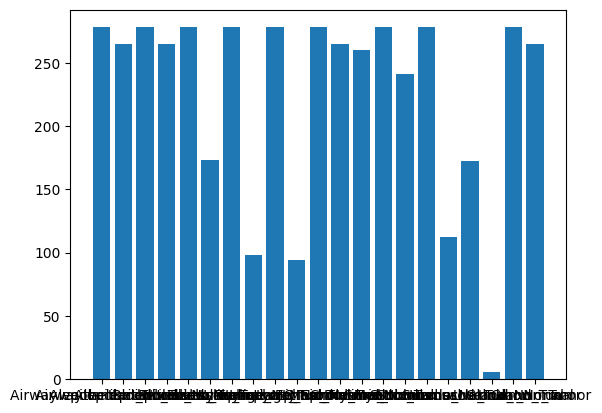

In [48]:
plt.bar(num_cells.keys(), height=num_cells.values())
plt.xlabels(rot=90)

#### Overexpressed

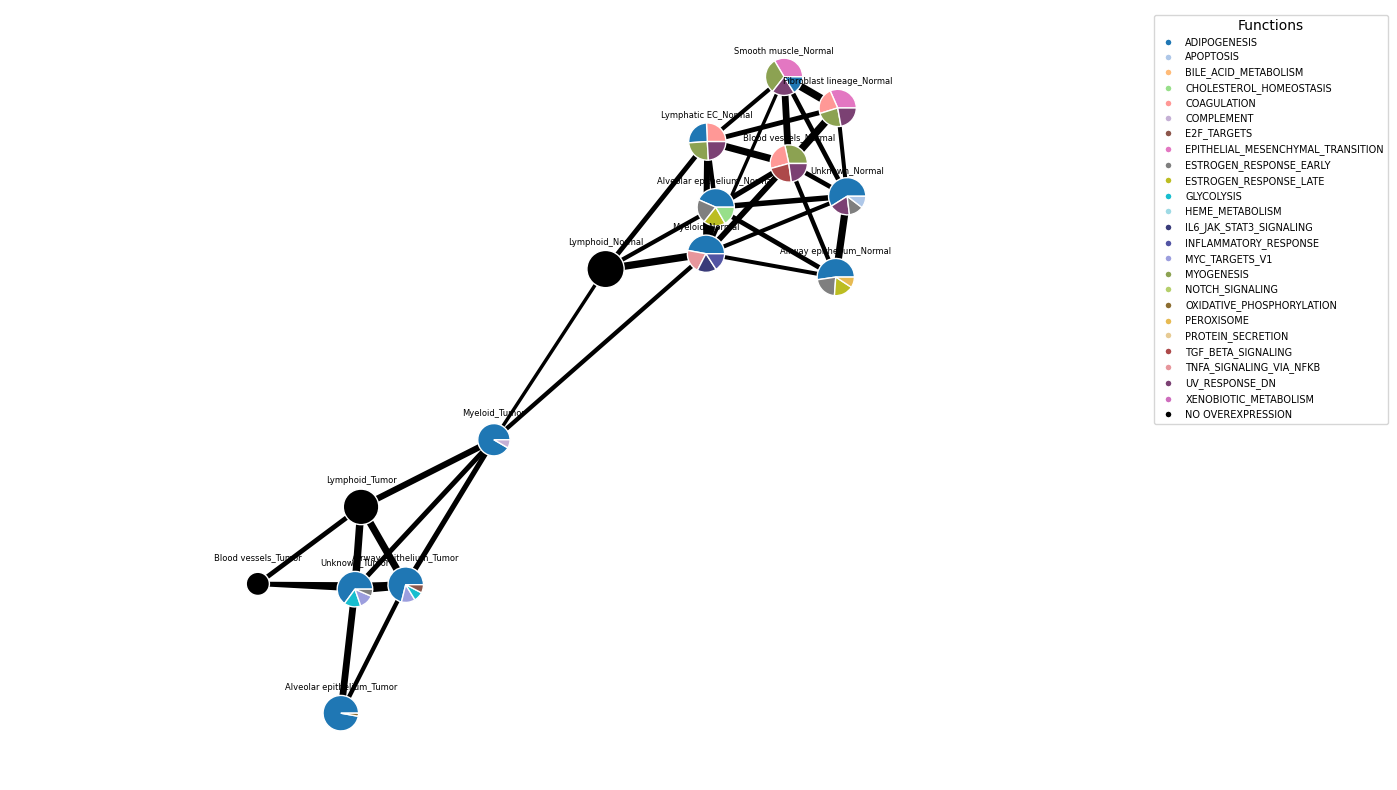

<Axes: >

In [75]:
ut.functional_network_plot(G_spear, node_pie_over, num_cells=num_cells, 
                           figsize=(14, 10), weight_key='weight')

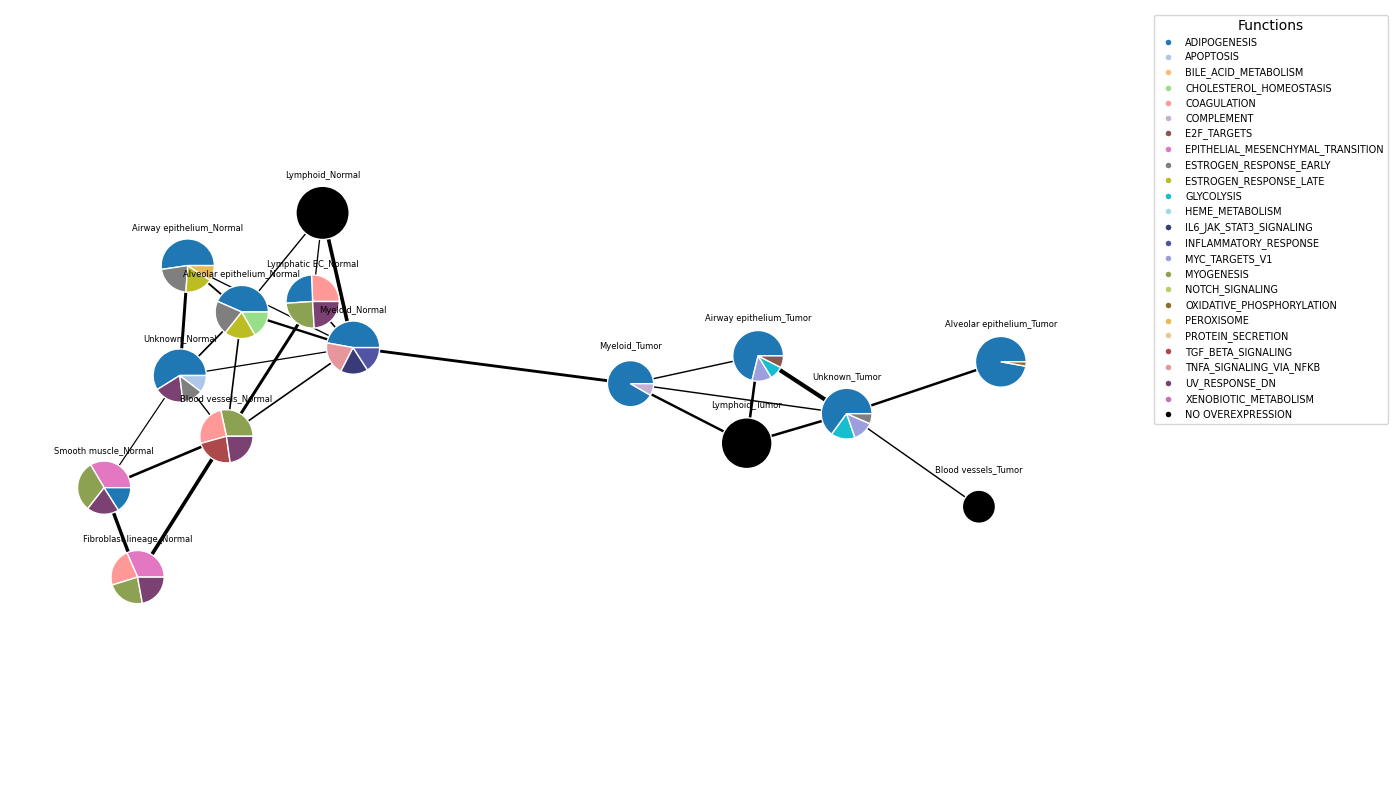

<Axes: >

In [308]:
functional_network_plot(G, node_pie_over, num_cells=num_cells, figsize=(14, 10))

#### Underexpressed

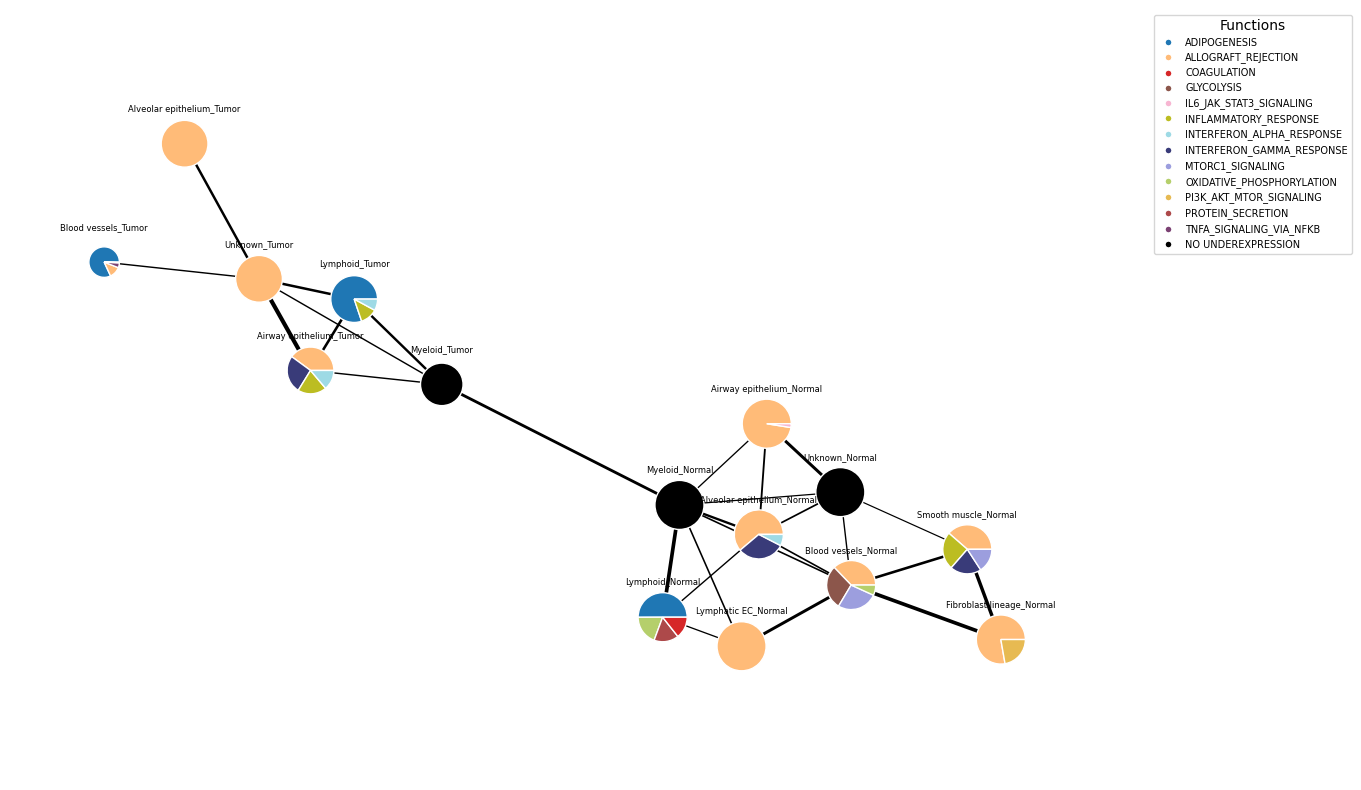

In [296]:
functional_network_plot(G, node_pie_under, num_cells=num_cells, figsize=(14, 10))

## MI with sklearn (deprecated)

In [84]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score

We won't use the function `mutual_info_score` because it is for labels assigned to a same observation. Which is not the case 
here because we are counting ocurrence of cells and no two cells should have more than one type.

So we use the `mutual_info_classif` though it is pretty unstable and does not use the same method than ARACNE.

**TODO:** compare the two methods, apparently n_neighbours is better at handling missing values?!?!?

To use discrete values we will rank the cell type in every sample based on a normalization by its total number of cells.

In [174]:
cells_x_sample = samp_type.transpose().sum().to_numpy()
percents = (samp_type / cells_x_sample.reshape(-1,1))*10
percents = percents.astype(int)
percents

Level_2_transfered_label,Airway epithelium,Alveolar epithelium,Blood vessels,Fibroblast lineage,Lymphatic EC,Lymphoid,Mesothelium,Myeloid,Smooth muscle,Unknown
sample,,,,,,,,,,
1247_Lambrechts,0,2,0,0,0,3,0,3,0,0
BRONCHO_11_Kim,0,0,0,0,0,7,0,2,0,0
BRONCHO_58_Kim,0,1,0,0,0,6,0,1,0,0
BT1249_Lambrechts,1,0,0,3,0,2,0,2,0,0
BT1A_Lambrechts,1,0,0,0,0,5,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...
patient_45_tumor_primary_Goveia,0,0,4,0,0,0,0,0,0,2
patient_46_normal_adjacent_Goveia,0,0,1,0,0,0,0,6,0,0
patient_46_tumor_primary_Goveia,1,1,2,0,0,0,0,0,0,2


Lets try with 10 ranks first. We should maybe look at the histogram to define the ranks but later.

In [167]:
percents.quantile([0.25,0.5,0.75])

Level_2_transfered_label,Airway epithelium,Alveolar epithelium,Blood vessels,Fibroblast lineage,Lymphatic EC,Lymphoid,Mesothelium,Myeloid,Smooth muscle,Unknown
0.25,0.555112,0.095459,0.080835,0.090000,0.000000,12.106691,0.0,12.803444,0.000000,1.073977
0.50,2.155407,1.019274,0.441795,0.530837,0.000000,35.717875,0.0,25.158388,0.049634,3.158462
0.75,11.011905,4.148505,1.565885,2.462523,0.107153,60.486871,0.0,44.321183,0.238419,9.326886


In [180]:
mis = []

for col in percents.columns:
    
    mis.append(mutual_info_classif(percents.to_numpy(),percents[col].to_numpy().reshape(-1,1)))
    
pd.DataFrame(mis, columns=percents.columns, index = percents.columns)

/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Level_2_transfered_label,Airway epithelium,Alveolar epithelium,Blood vessels,Fibroblast lineage,Lymphatic EC,Lymphoid,Mesothelium,Myeloid,Smooth muscle,Unknown
Level_2_transfered_label,,,,,,,,,,
Airway epithelium,1.054760e+00,5.498831e-01,3.326694e-01,4.077500e-01,1.264831e-01,1.390151e-01,4.939621e-01,4.922736e-02,4.321303e-01,0.000000e+00
Alveolar epithelium,0.000000e+00,6.438520e-01,2.373198e-01,2.415227e-01,4.240108e-02,6.390419e-02,3.454416e-01,7.780823e-02,2.860061e-01,2.874398e-02
Blood vessels,1.268936e-02,2.330745e-01,3.365842e-01,3.073920e-01,2.537583e-01,2.804300e-02,2.768843e-01,0.000000e+00,3.217768e-01,0.000000e+00
Fibroblast lineage,2.326619e-03,5.747926e-02,1.472116e-01,3.696483e-01,1.481677e-01,2.477861e-03,2.179479e-01,1.900580e-03,2.129614e-01,1.731524e-02
Lymphatic EC,0.000000e+00,0.000000e+00,8.131330e-03,0.000000e+00,4.811499e-02,0.000000e+00,3.892864e-02,0.000000e+00,4.155331e-02,2.374098e-03
Lymphoid,1.483189e-01,9.485741e-02,6.735740e-02,0.000000e+00,1.098557e-01,1.333505e+00,6.050899e-02,4.374144e-01,3.717078e-02,1.221909e-01
Mesothelium,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16
Myeloid,1.562561e-02,2.437624e-01,2.578793e-02,1.247594e-01,9.637084e-02,3.219901e-01,0.000000e+00,1.492556e+00,8.698299e-02,1.098791e-01
Smooth muscle,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16


tener las unidades en bits te sirve para comparar que tantos bits pueden compartir dos cosas

This binning is not as efficient as the one from ARACNE because the Gaussina copula method considers variance also, besides the static width. So we will use the method from ARACNE and in that way, we also wont have to normalize for ourselves.